# deepBreaks applications
## Predicting the subtype of the HIV-1 virus based on its V3 amino-acid sequence   
PLACEHOLDER FOR DESCRIPTION
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1868395/
<p style="text-align:center;">
<figure>
  <img src="../img/HIV/v3.png" alt="V3" style="width: 400px;">
    <figcaption>Image from: <a size=10 href=https://doi.org/10.1371/journal.pcbi.0030058>Sander, Oliver, et al. "Structural descriptors of gp120 V3 loop for the prediction of HIV-1 coreceptor usage." PLoS computational biology 3.3 (2007): e58.</a> 
        </figcaption>
</figure>
</p>

In [1]:
# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data, balanced_classes
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all
import warnings
import datetime
import os

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = '~/Documents/RahLab/deepBreaks_data/HIV/hiv_V3_B_C_nu_clean.fasta'
meta_data_fileName = '~/Documents/RahLab/deepBreaks_data/HIV/results_V3_B_C_meta.csv'
# name of the phenotype
mt = 'Subtype'

# type of the sequences
seq_type = 'nu'
# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'cl'

In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [7]:
%%time
# importing sequences data
print('reading meta-data')
# importing metadata
meta_data = read_data(meta_data_fileName, seq_type = None, is_main=False)

# importing sequences data
print('reading fasta file')
tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=0.7)

tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True, how='inner')
y = tr.loc[:, mt].values
tr.drop(mt, axis=1, inplace=True)
print('Shape of data is: ', tr.shape)

reading meta-data
reading fasta file
Shape of data is:  (35424, 105)
CPU times: user 1.53 s, sys: 31.8 ms, total: 1.57 s
Wall time: 1.57 s


In [8]:
tr.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p96,p97,p98,p99,p100,p101,p102,p103,p104,p105
A04321,T,G,T,A,C,A,A,G,A,C,...,A,G,C,A,C,A,T,T,G,T
AB001137,T,G,T,A,C,A,A,G,A,C,...,A,G,C,A,C,A,T,T,G,T
AB002829,T,G,T,A,C,A,A,G,A,C,...,A,G,C,A,C,A,T,T,G,T
AB002844,T,G,T,A,C,A,A,G,A,C,...,A,G,C,A,C,A,T,T,G,T
AB002872,T,G,T,A,C,A,A,G,A,C,...,A,G,C,A,C,A,T,T,G,T


**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [9]:
print('metadata looks like this:')
meta_data.head()

metadata looks like this:


,Subtype
A04321,B
AB001137,B
AB002829,B
AB002844,B
AB002872,B


In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)

['B' 'C']


### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [14]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.25)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.05)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.25)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.25))
    ])

In [15]:
%%time
report, top = model_compare_cv(X=tr, y=y, preprocess_pipe=prep_pipeline,
                               models_dict=get_models(ana_type=ana_type),
                               scoring=get_scores(ana_type=ana_type),
                               report_dir=report_dir,
                               cv=10, ana_type=ana_type, cache_dir=None)

Fitting rf...
Fitting Adaboost...
Fitting et...
Fitting lg...
Fitting gbc...
Fitting dt...
Fitting xgb...
Fitting lgbm...
CPU times: user 9.91 s, sys: 4.69 s, total: 14.6 s
Wall time: 1min 19s


In [16]:
report

,Accuracy,AUC,F1,Recall,Precision
lgbm,0.995257,0.999139,0.994558,0.994404,0.994719
xgb,0.995201,0.999034,0.994496,0.994347,0.994652
et,0.995201,0.998639,0.994492,0.994095,0.994897
rf,0.994919,0.998974,0.994165,0.993739,0.994600
gbc,0.994749,0.999081,0.993973,0.993935,0.994016
lg,0.994495,0.999028,0.993679,0.993678,0.993686
Adaboost,0.992858,0.998889,0.991812,0.992454,0.991184
dt,0.990007,0.988625,0.988541,0.988270,0.988831


In [17]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.25)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.05)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.25, keep=True)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.25, keep=True))
    ])

In [18]:
modified_top = []
for model in top:
    modified_top.append(make_pipeline(steps=[('prep', prep_pipeline), model.steps[-1]]))

In [19]:
modified_top[0]

Pipeline(steps=[('prep',
                 Pipeline(steps=[('mc', MisCare(missing_threshold=0.25)),
                                 ('cc', ConstantCare()),
                                 ('ur', URareCare(threshold=0.05)),
                                 ('cc2', ConstantCare()),
                                 ('one_hot', CustomOneHotEncoder()),
                                 ('feature_selection',
                                  FeatureSelection(alpha=0.25, keep=True,
                                                   model_type='cl')),
                                 ('collinear_care',
                                  CollinearCare(dist_method='correlation',
                                                keep=True, threshold=0.25))])),
                ('lgbm', LGBMClassifier(random_state=123))])

In [20]:
%%time
top = finalize_top(X=tr, y=y, top_models=modified_top, grid_param={},report_dir=report_dir, cv=10)

Tuning lgbm...
Tuning xgb...
Tuning et...
CPU times: user 21.4 s, sys: 6.35 s, total: 27.7 s
Wall time: 8.27 s


In [21]:
%%time
sr = summarize_results(top_models=top, report_dir=report_dir)

CPU times: user 23.7 ms, sys: 3.97 ms, total: 27.7 ms
Wall time: 27.8 ms


In [22]:
sr.head()

,feature,p_value,score,lgbm,xgb,et,mean
0,p3_T,5.508571e-01,0.355784,0.000000,0.000000,0.000000,0.000000
1,p4_GTC,1.842006e-66,296.568972,0.162679,0.001992,0.003076,0.055916
2,p5_T,8.899074e-66,293.429359,0.191388,0.001377,0.003736,0.065500
3,p6_GCT,9.300775e-249,1134.739681,0.569378,0.004037,0.012554,0.195323
4,p9_G,4.148203e-39,171.150640,0.095694,0.001153,0.004570,0.033806


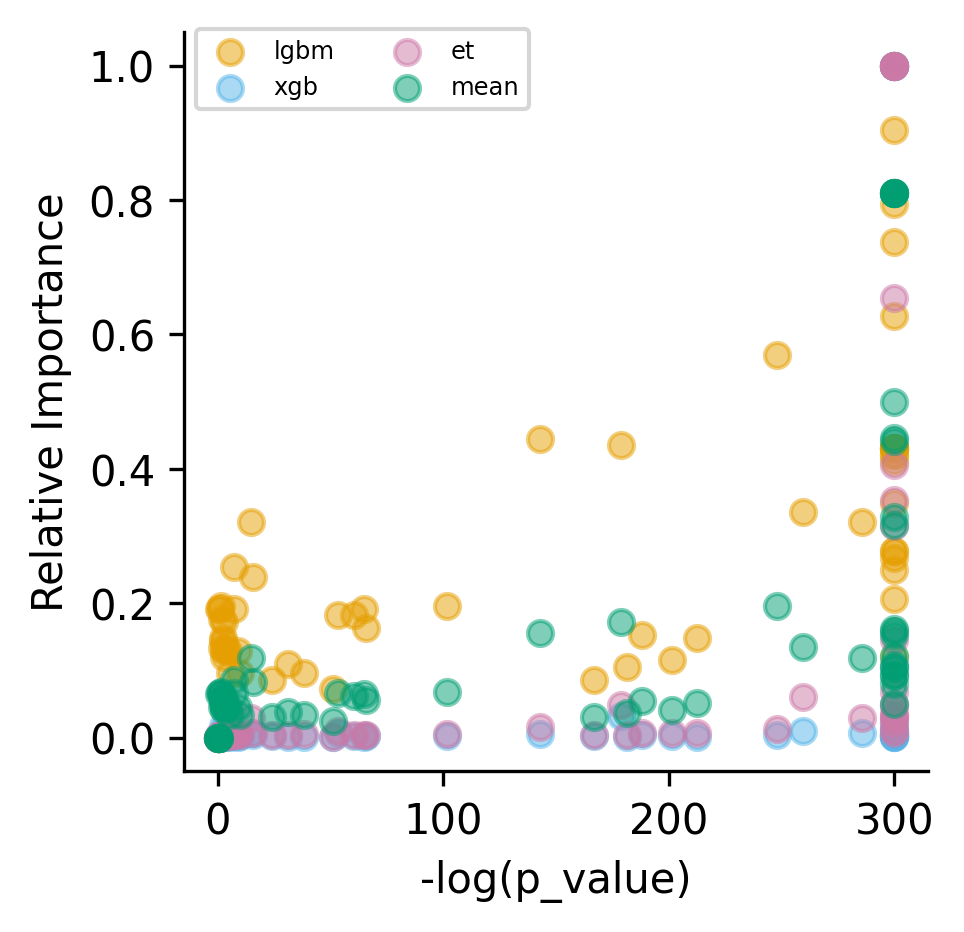

In [23]:
scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)

In [24]:
%%time
mean_imp = mean_importance(top, report_dir=report_dir)

CPU times: user 27.6 ms, sys: 5.27 ms, total: 32.9 ms
Wall time: 31.5 ms


mean Done


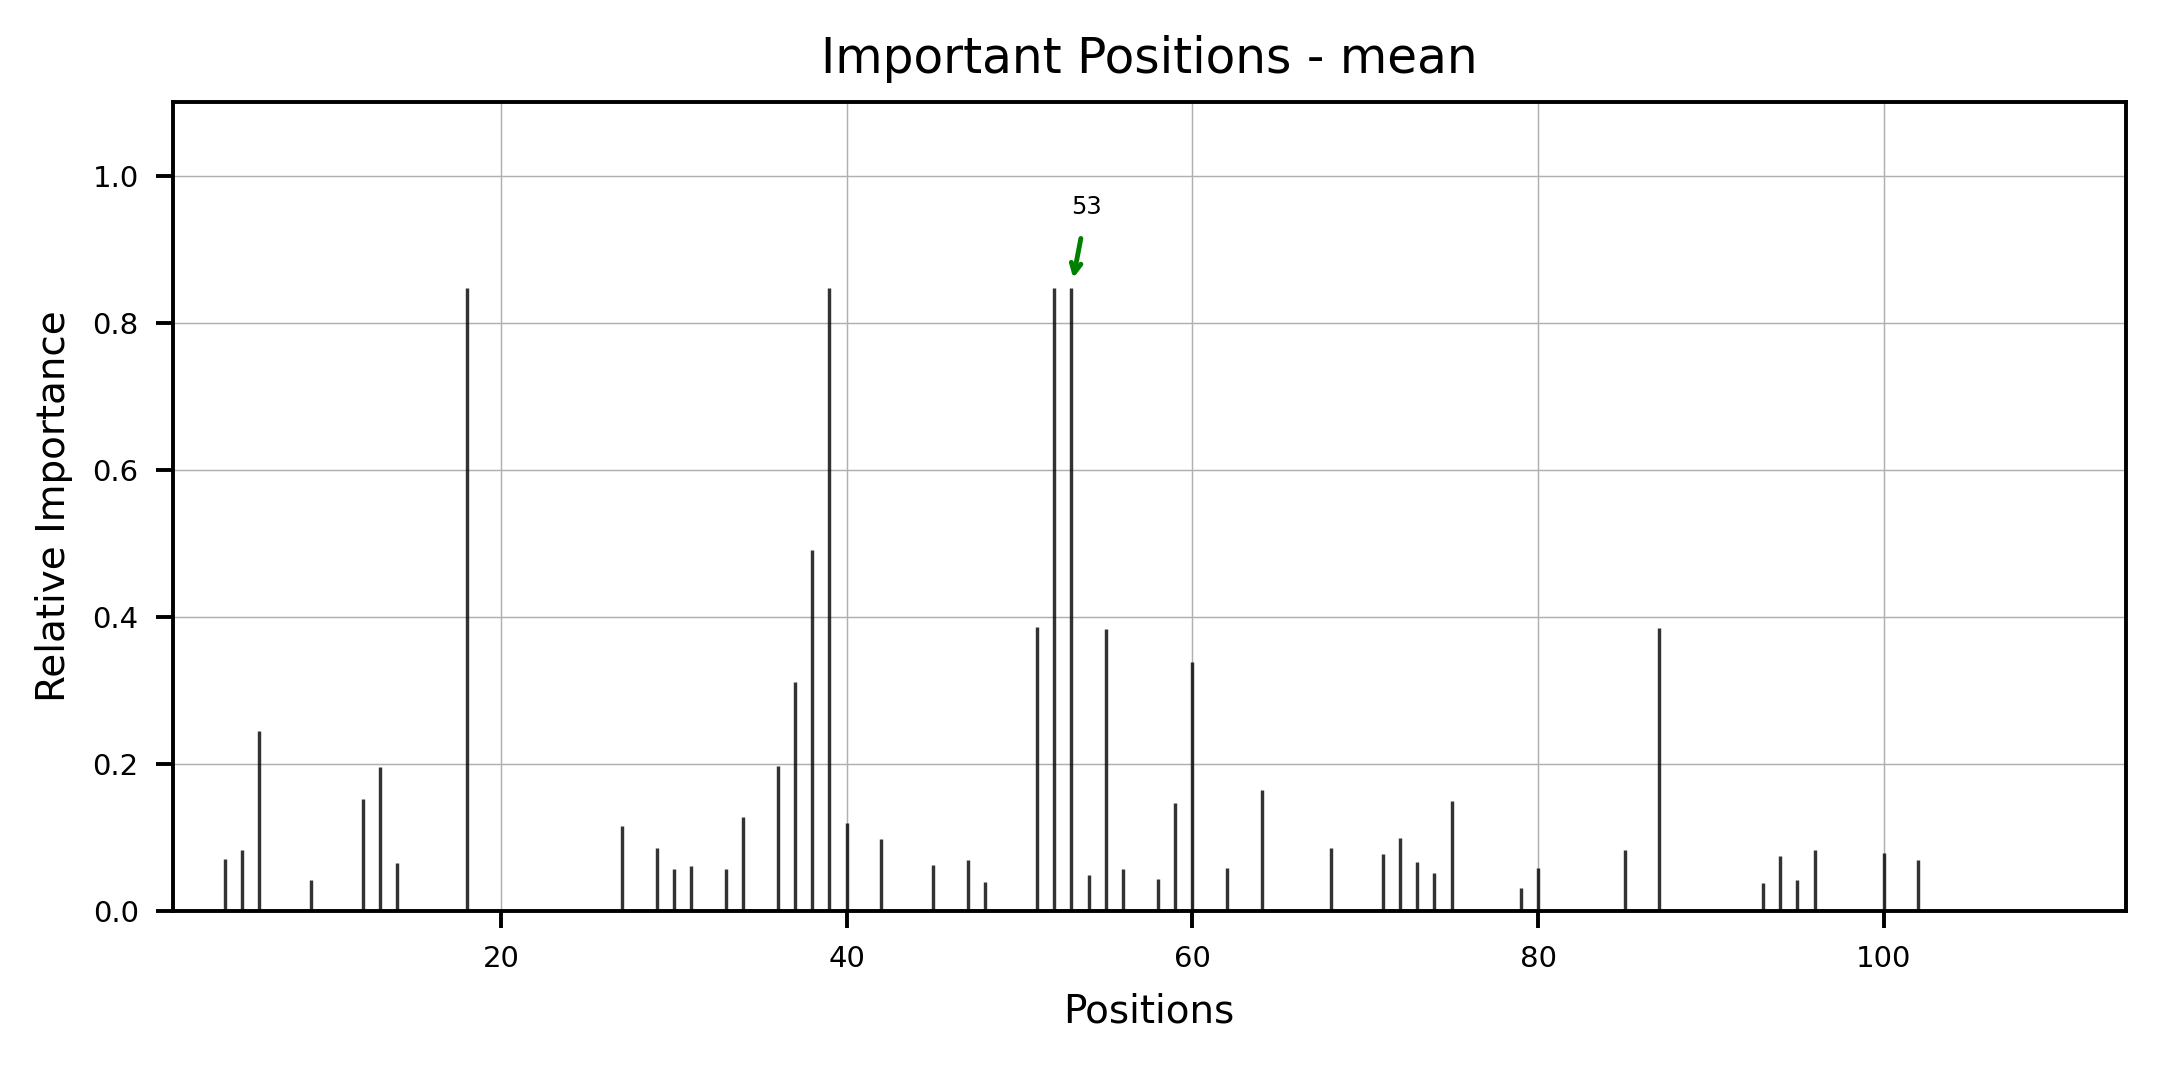

In [25]:
dp_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir)

In [26]:
tr = prep_pipeline[:4].fit_transform(tr)
y = le.inverse_transform(y)

lgbm Done
lgbm  Done
xgb Done
xgb  Done
et Done
et  Done


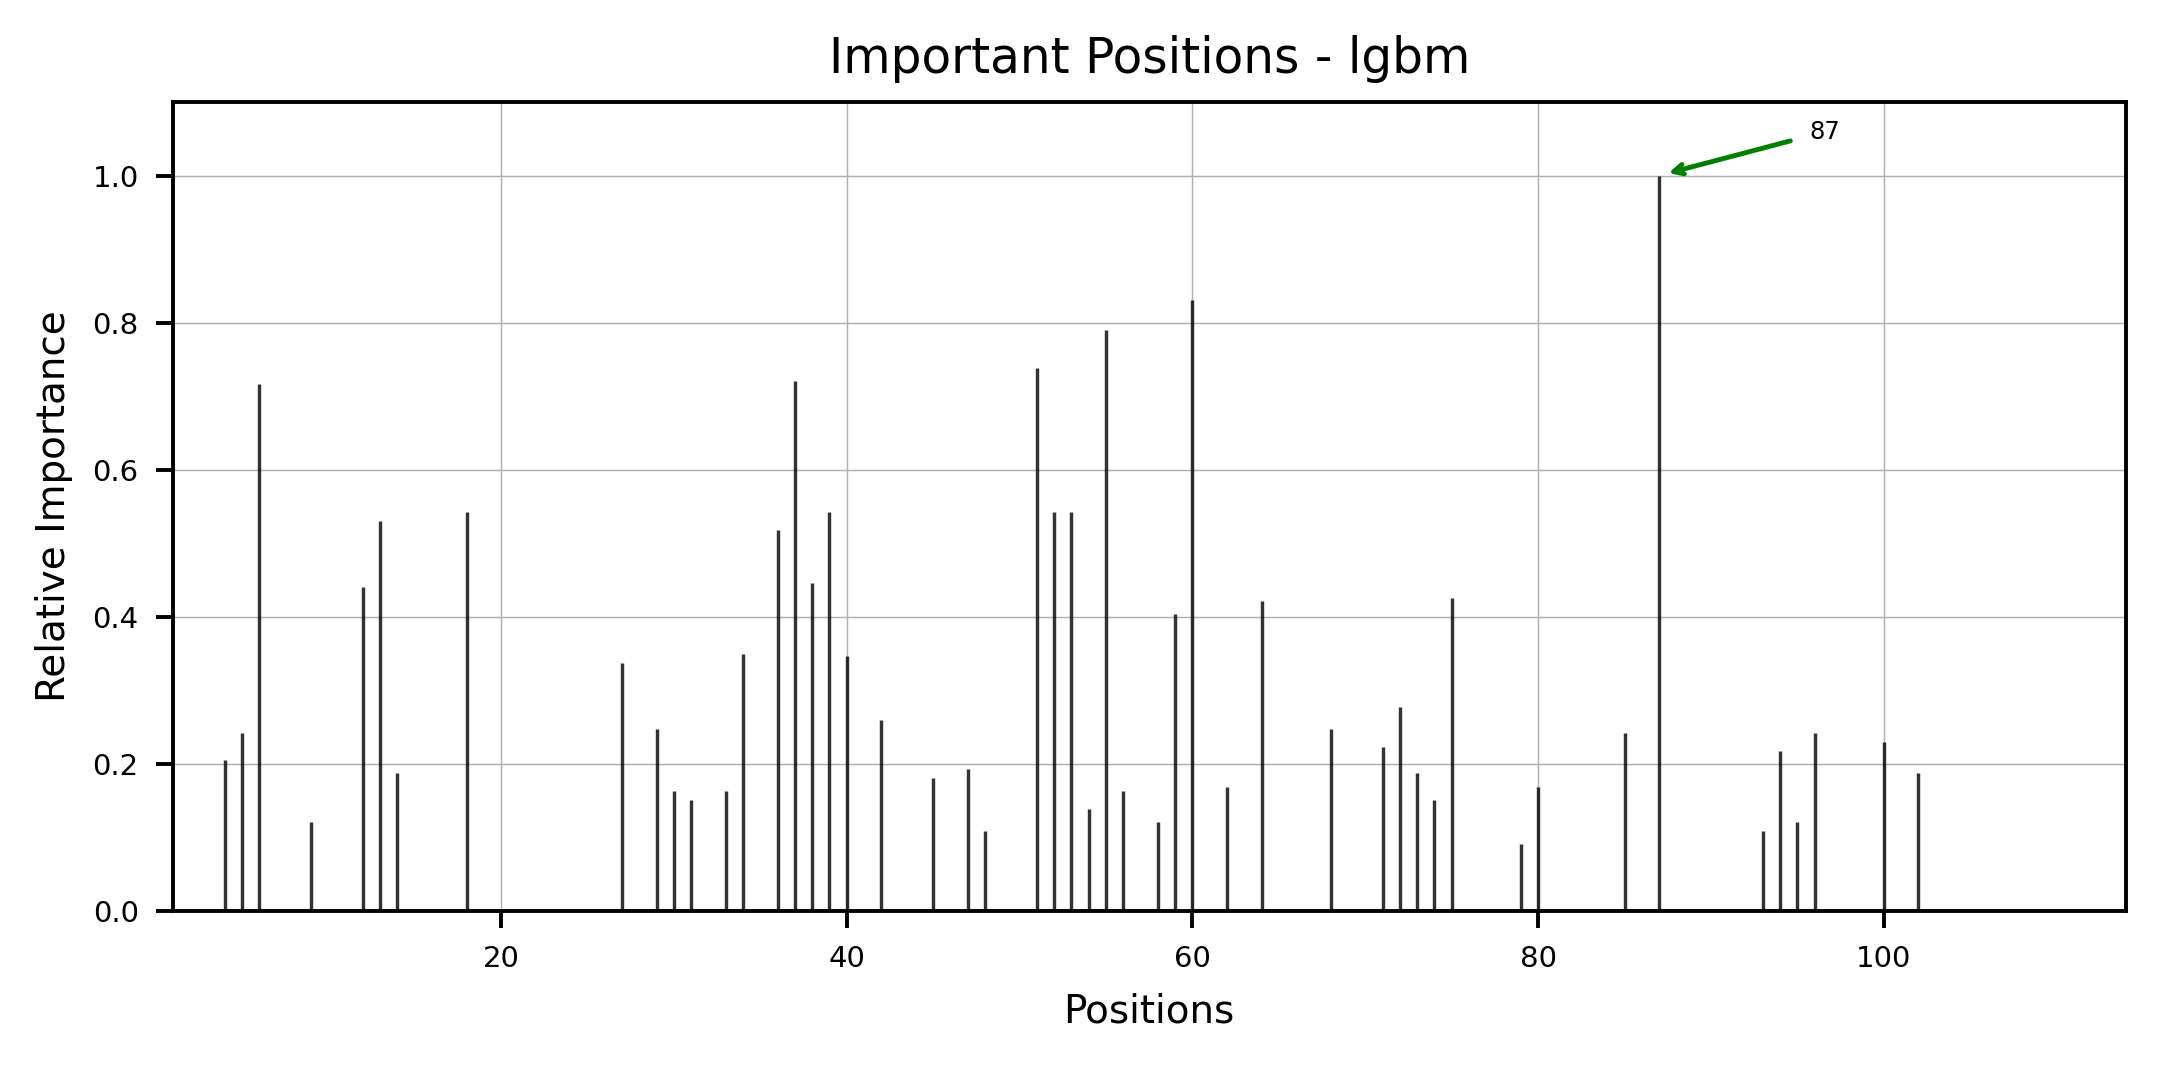

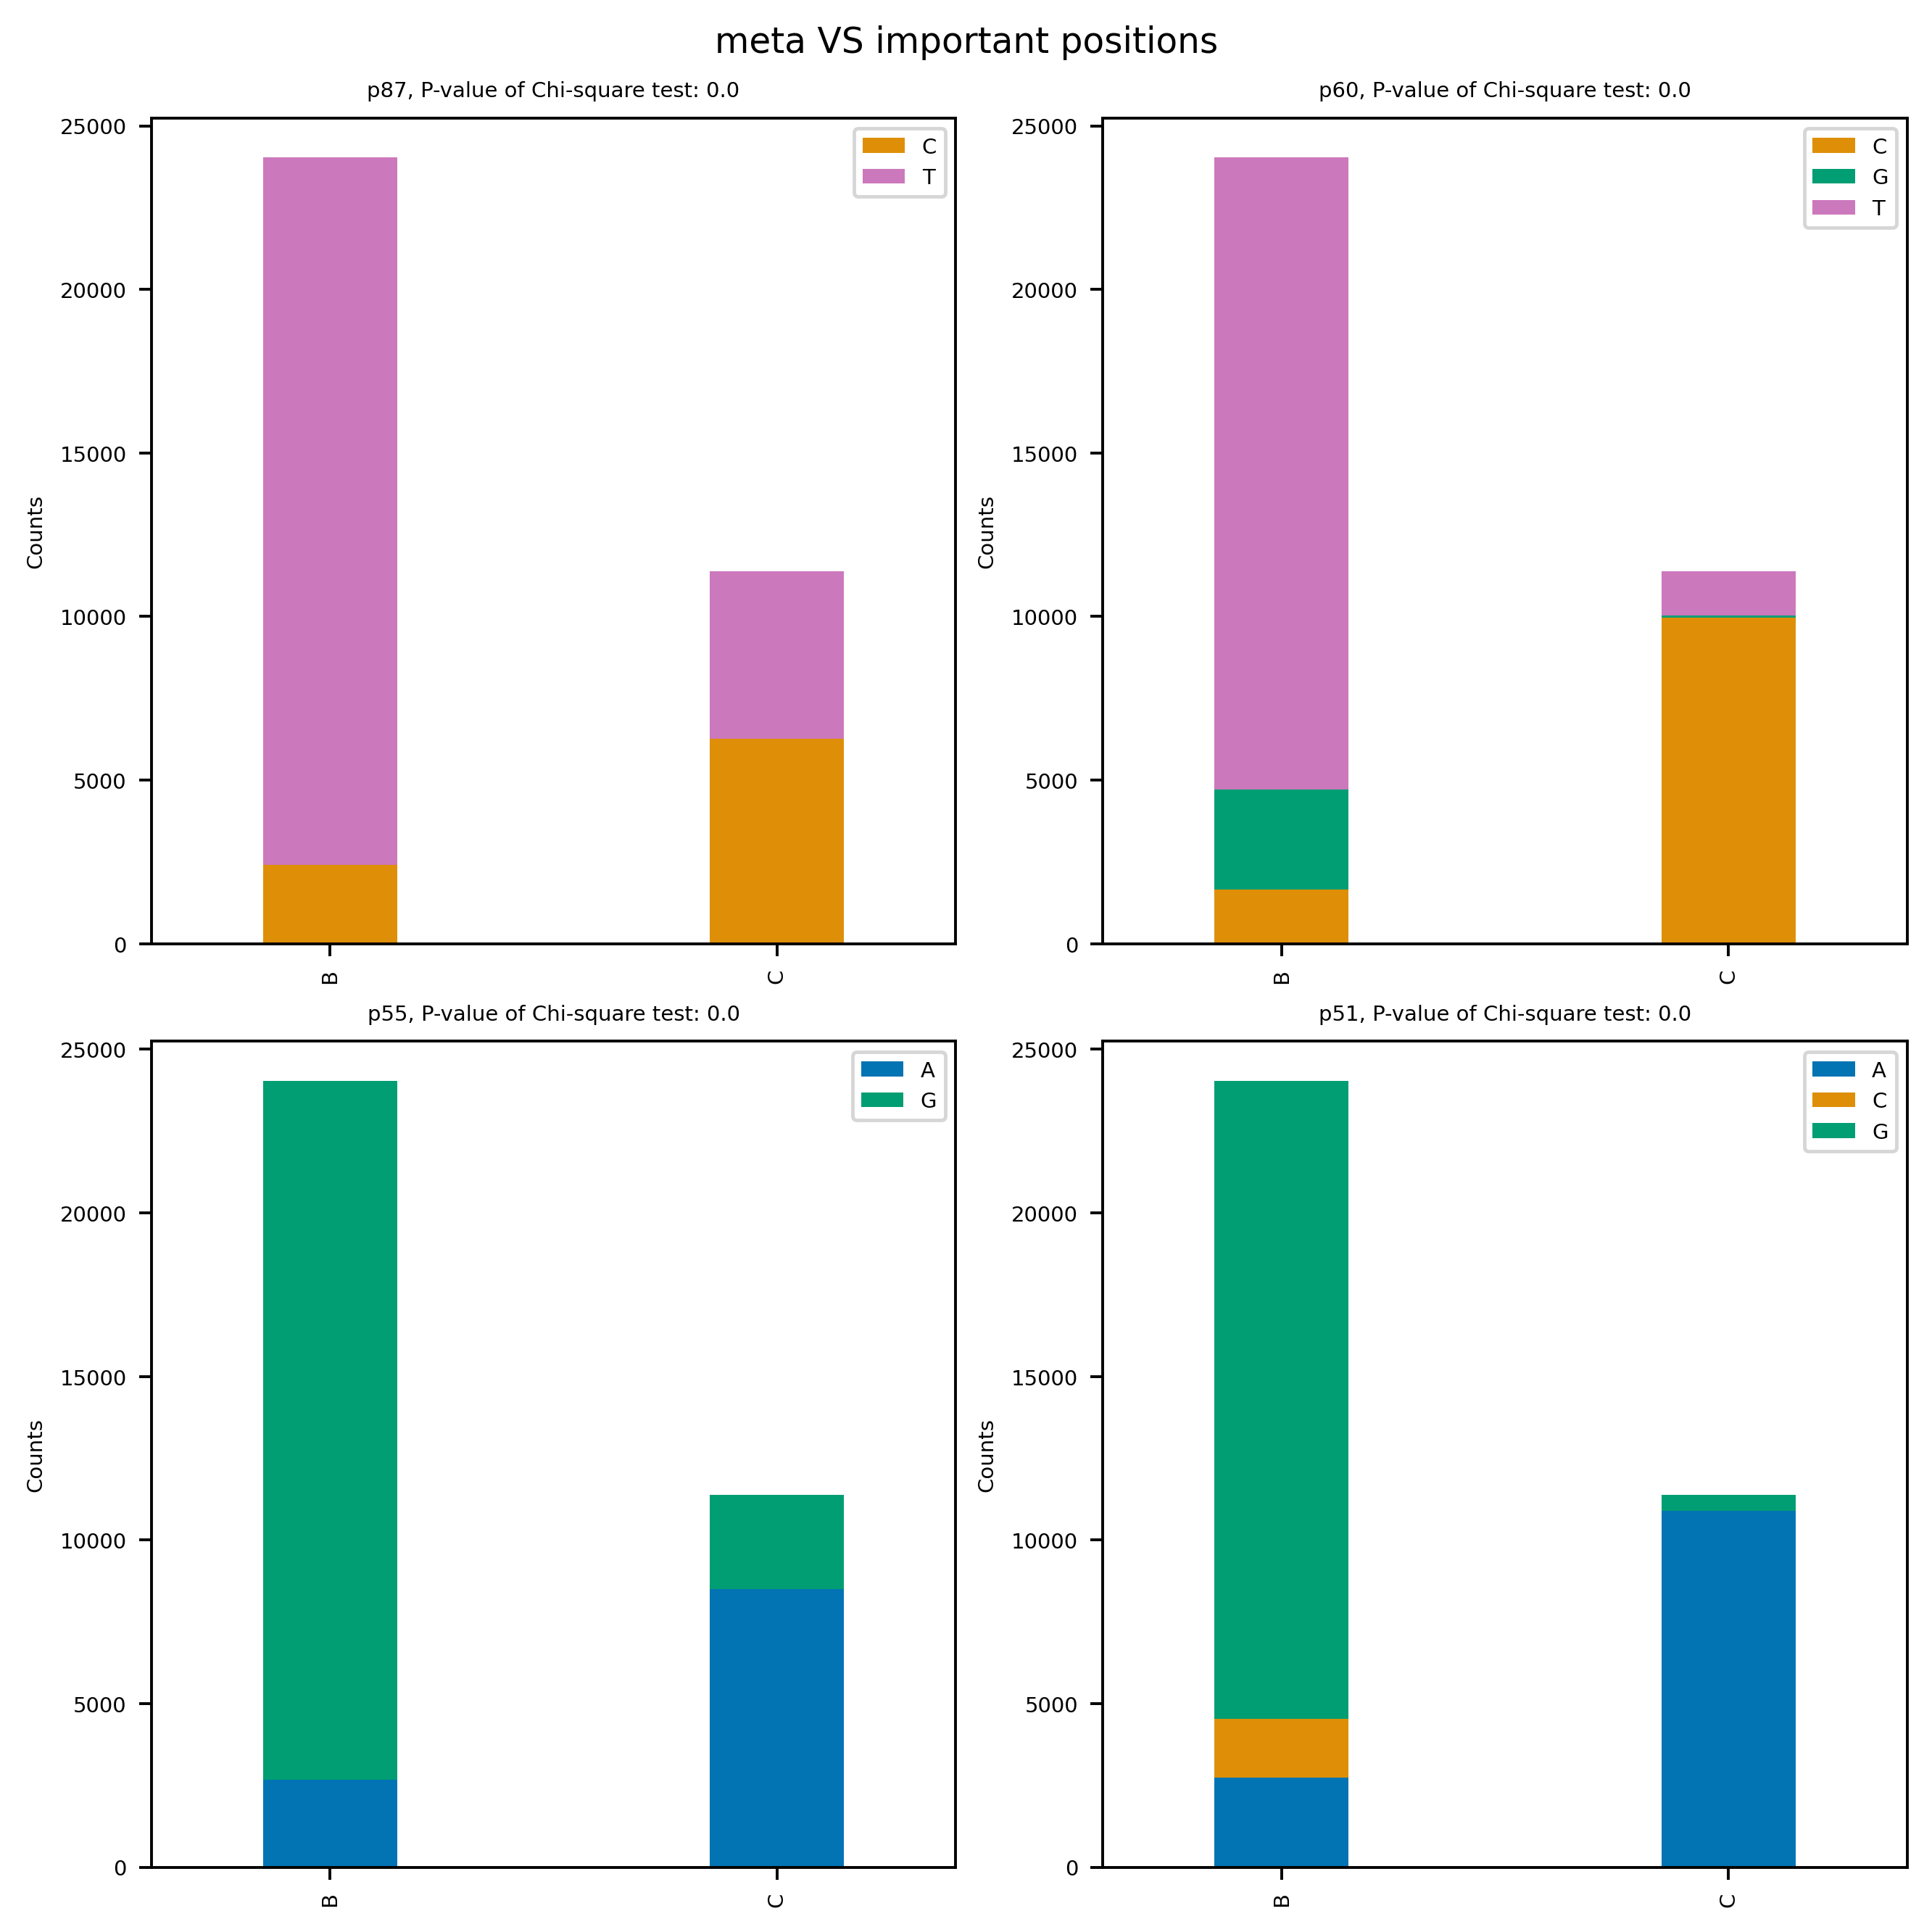

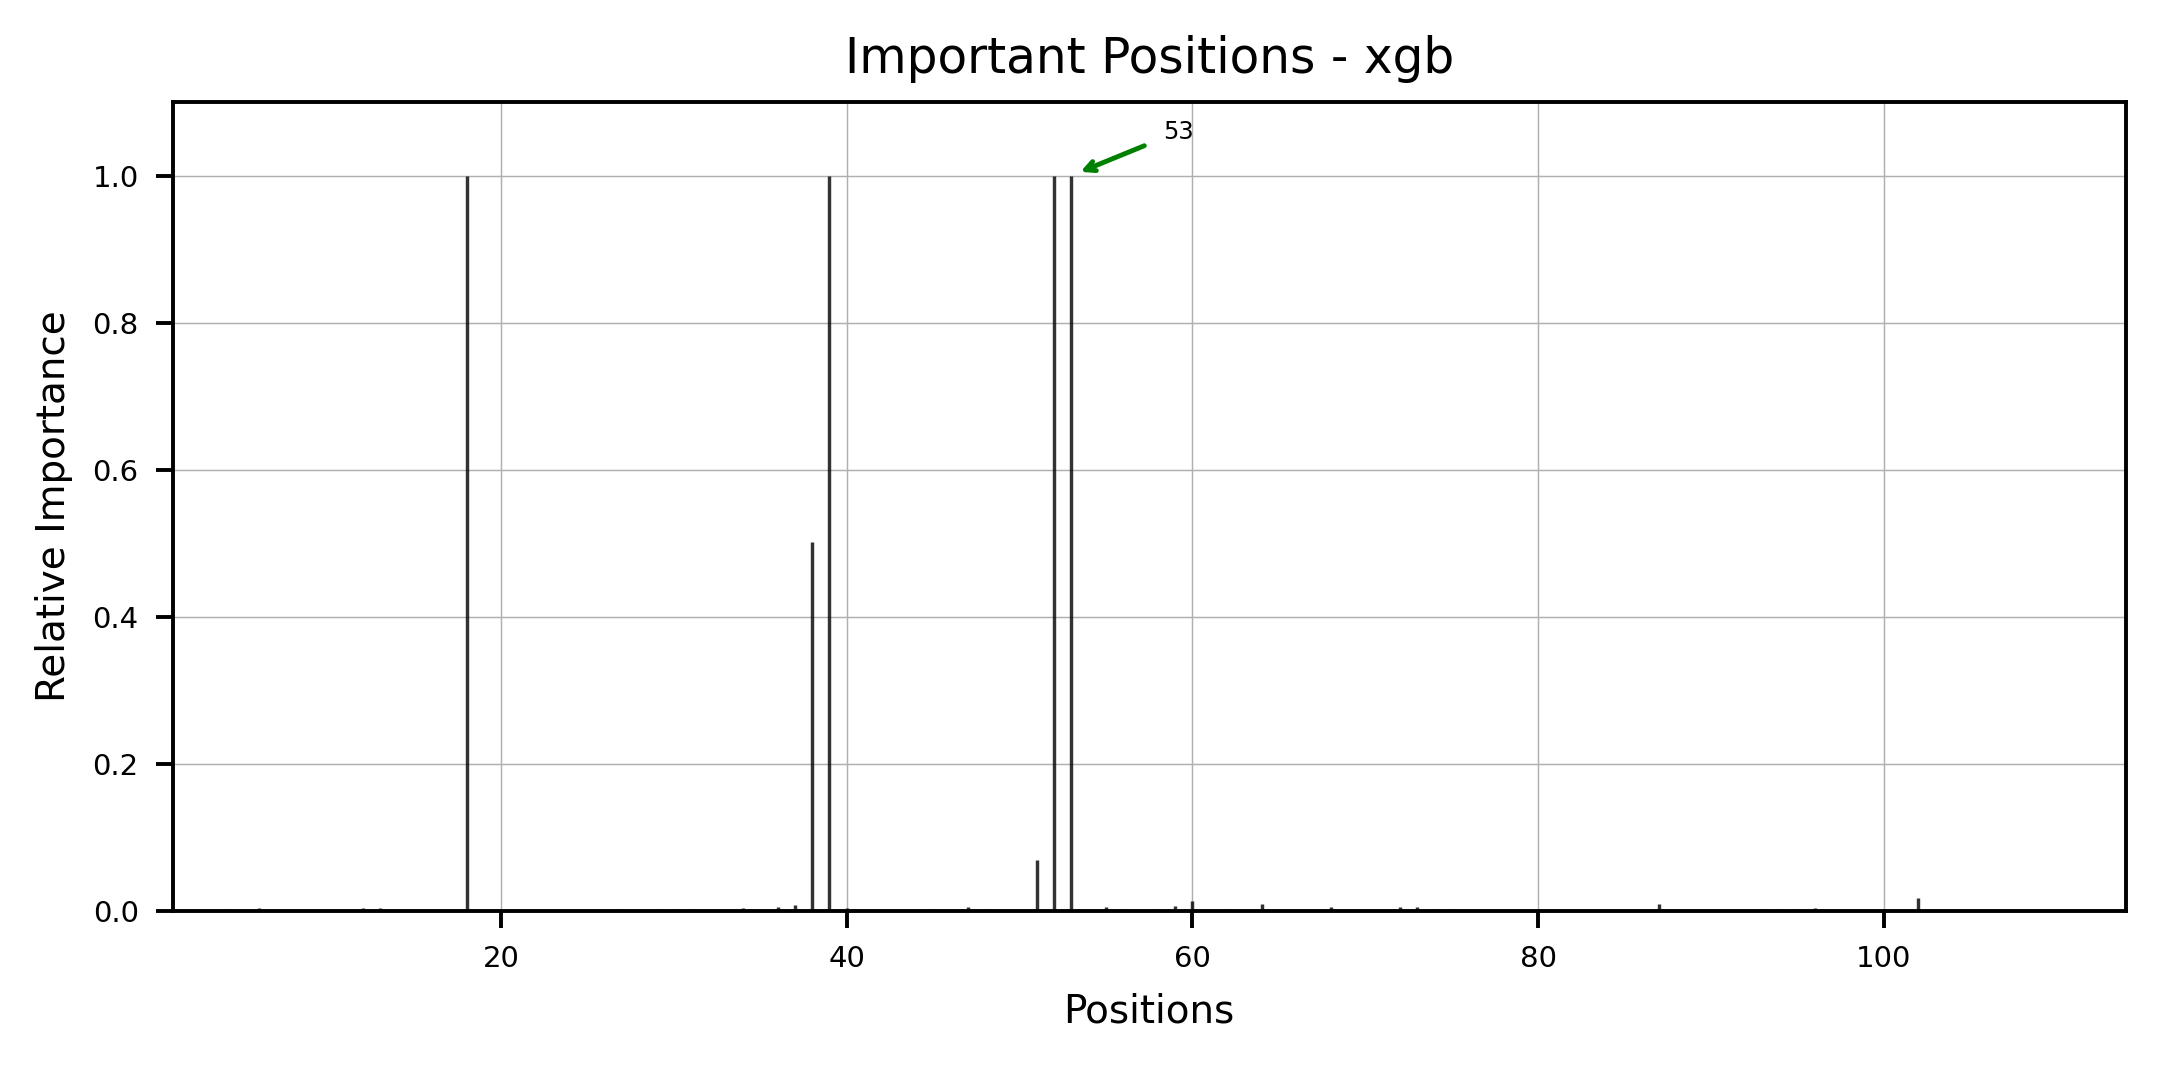

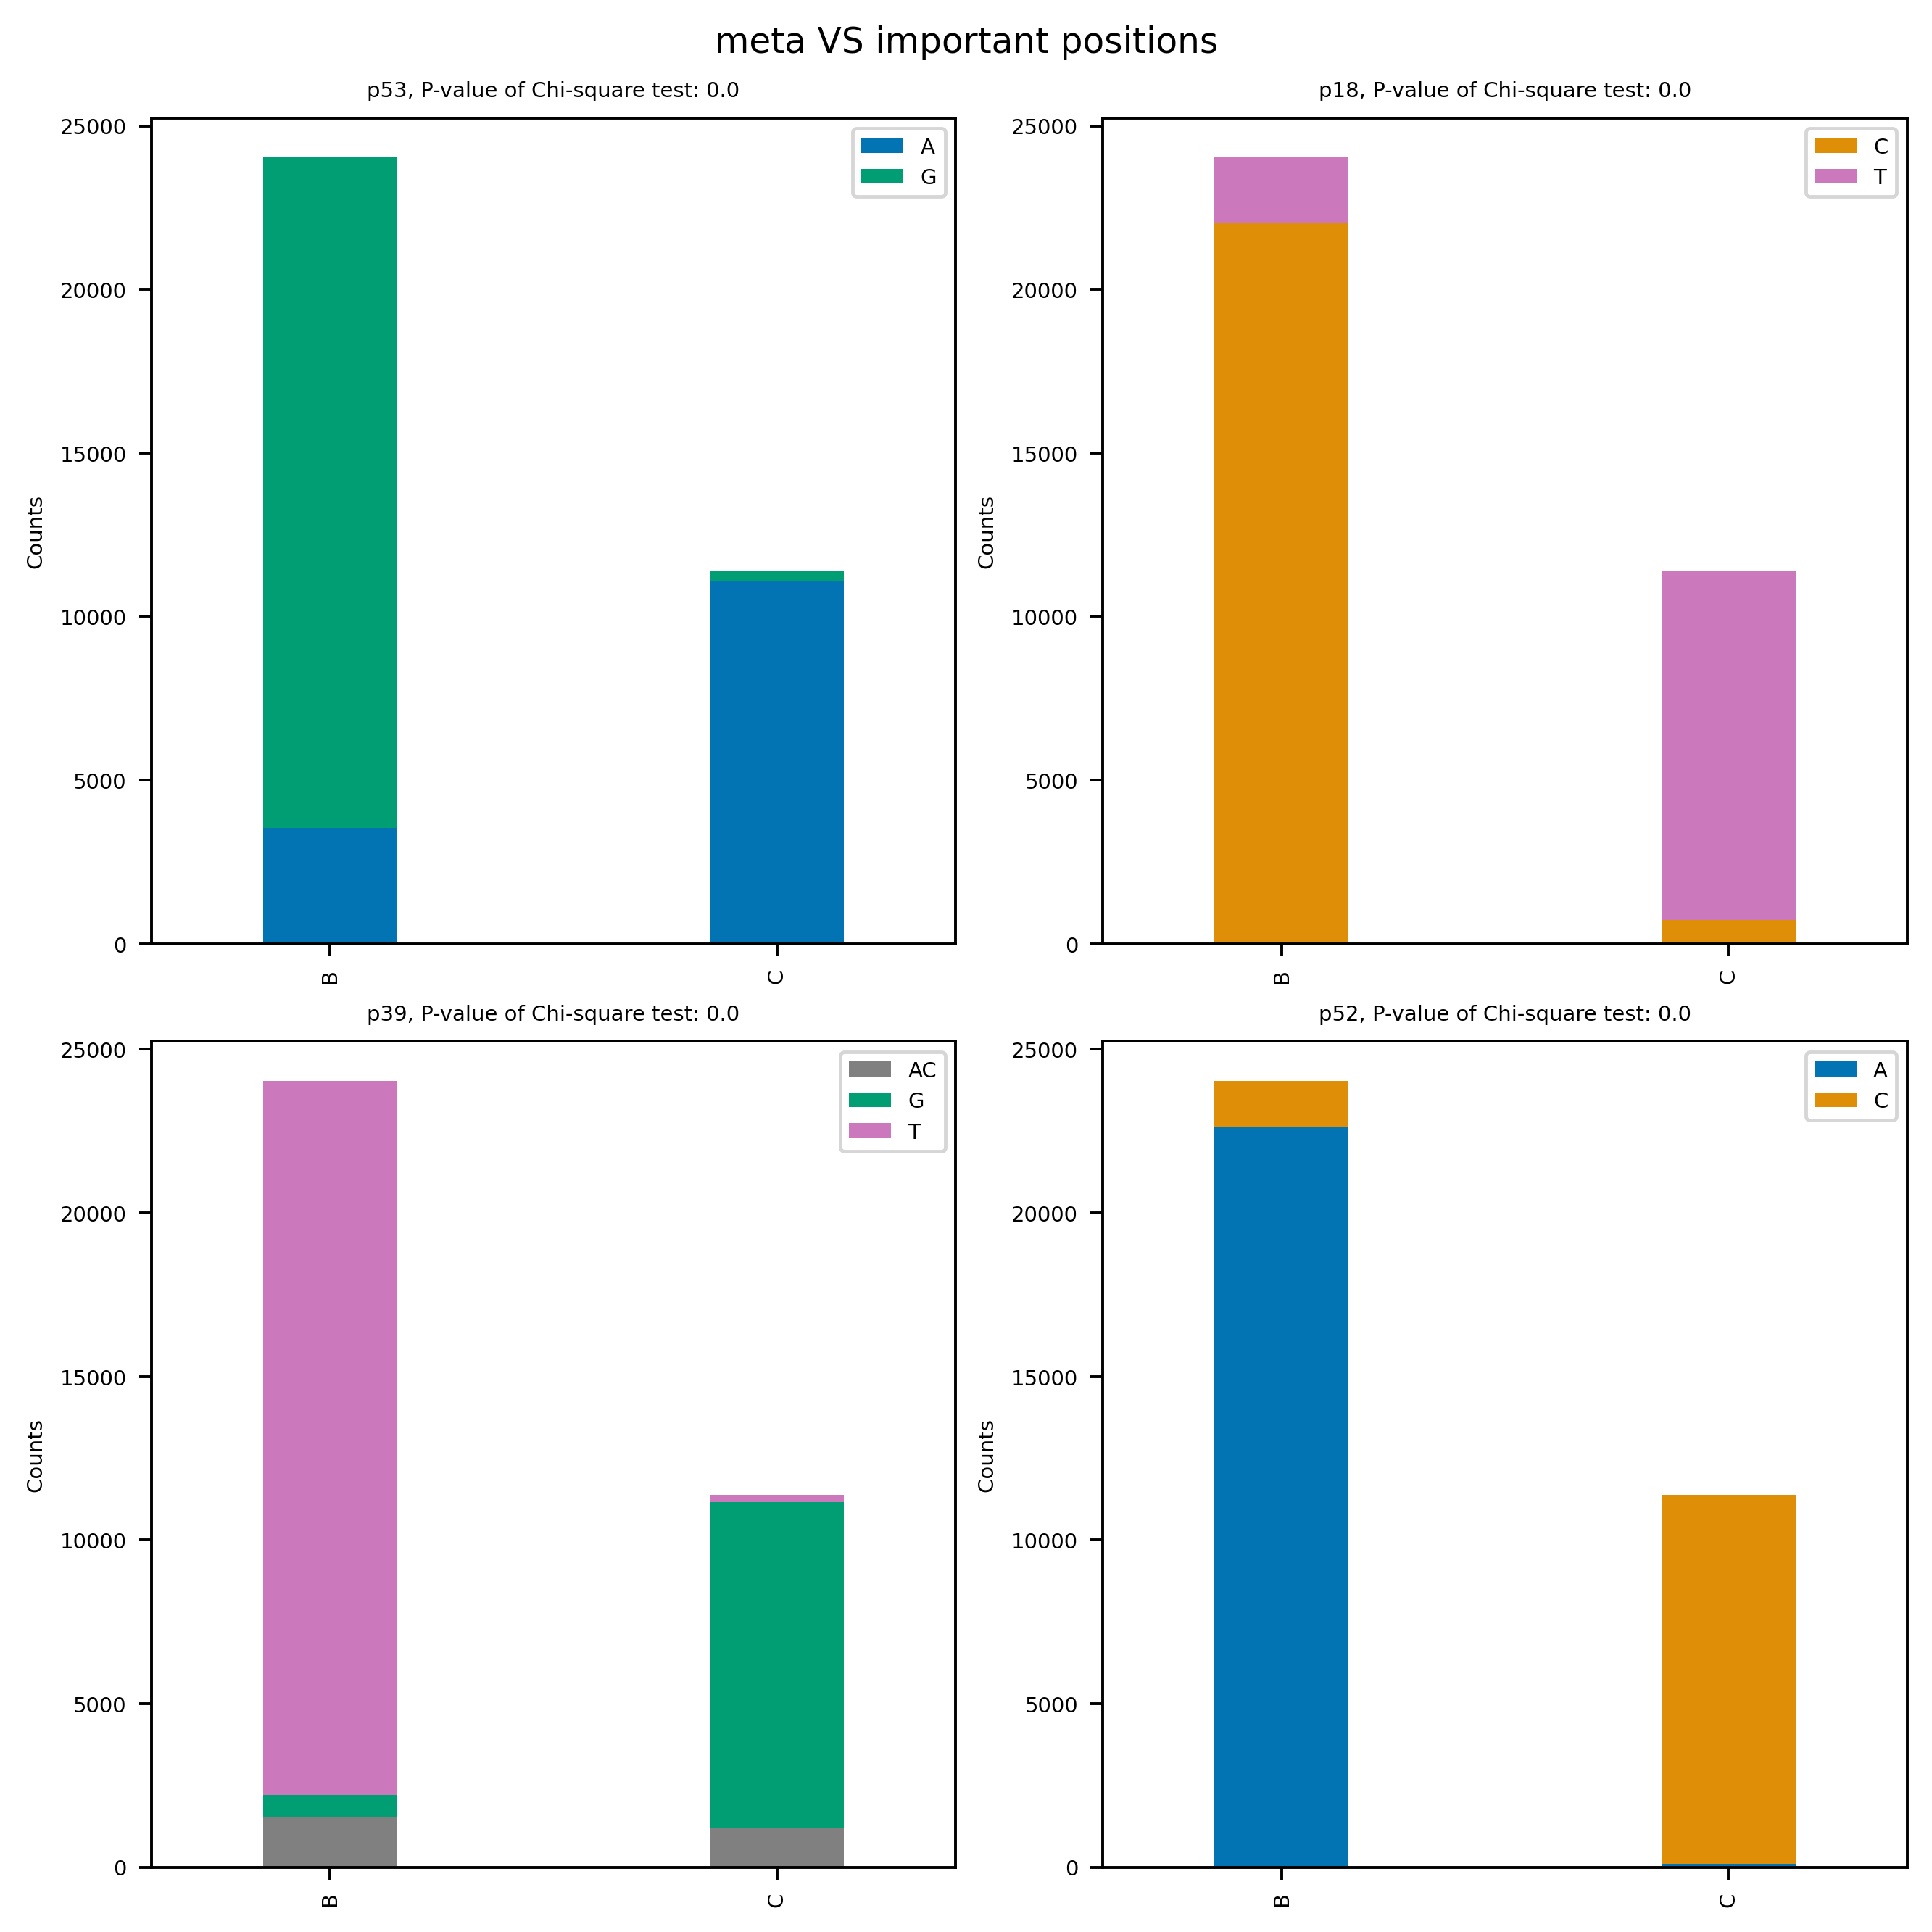

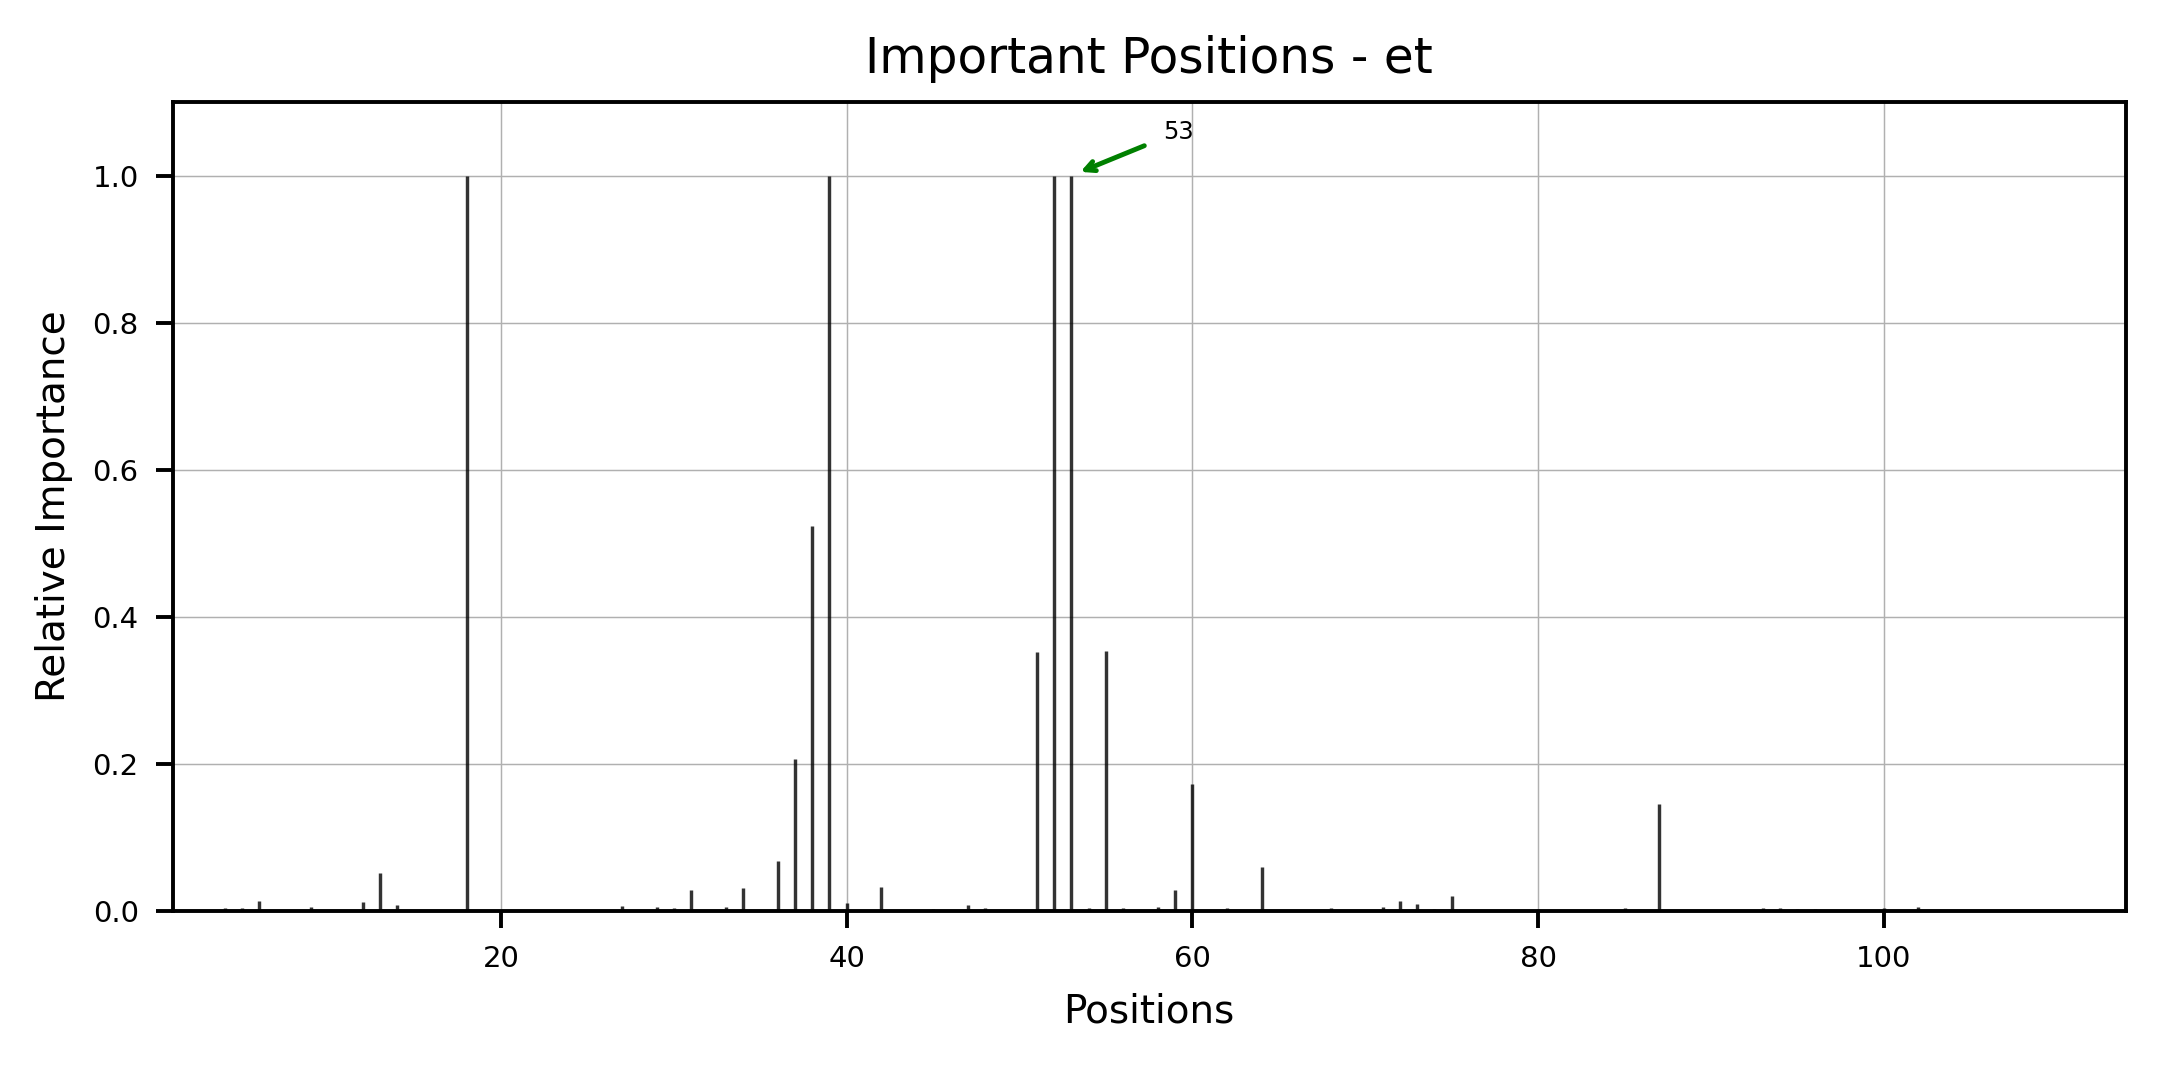

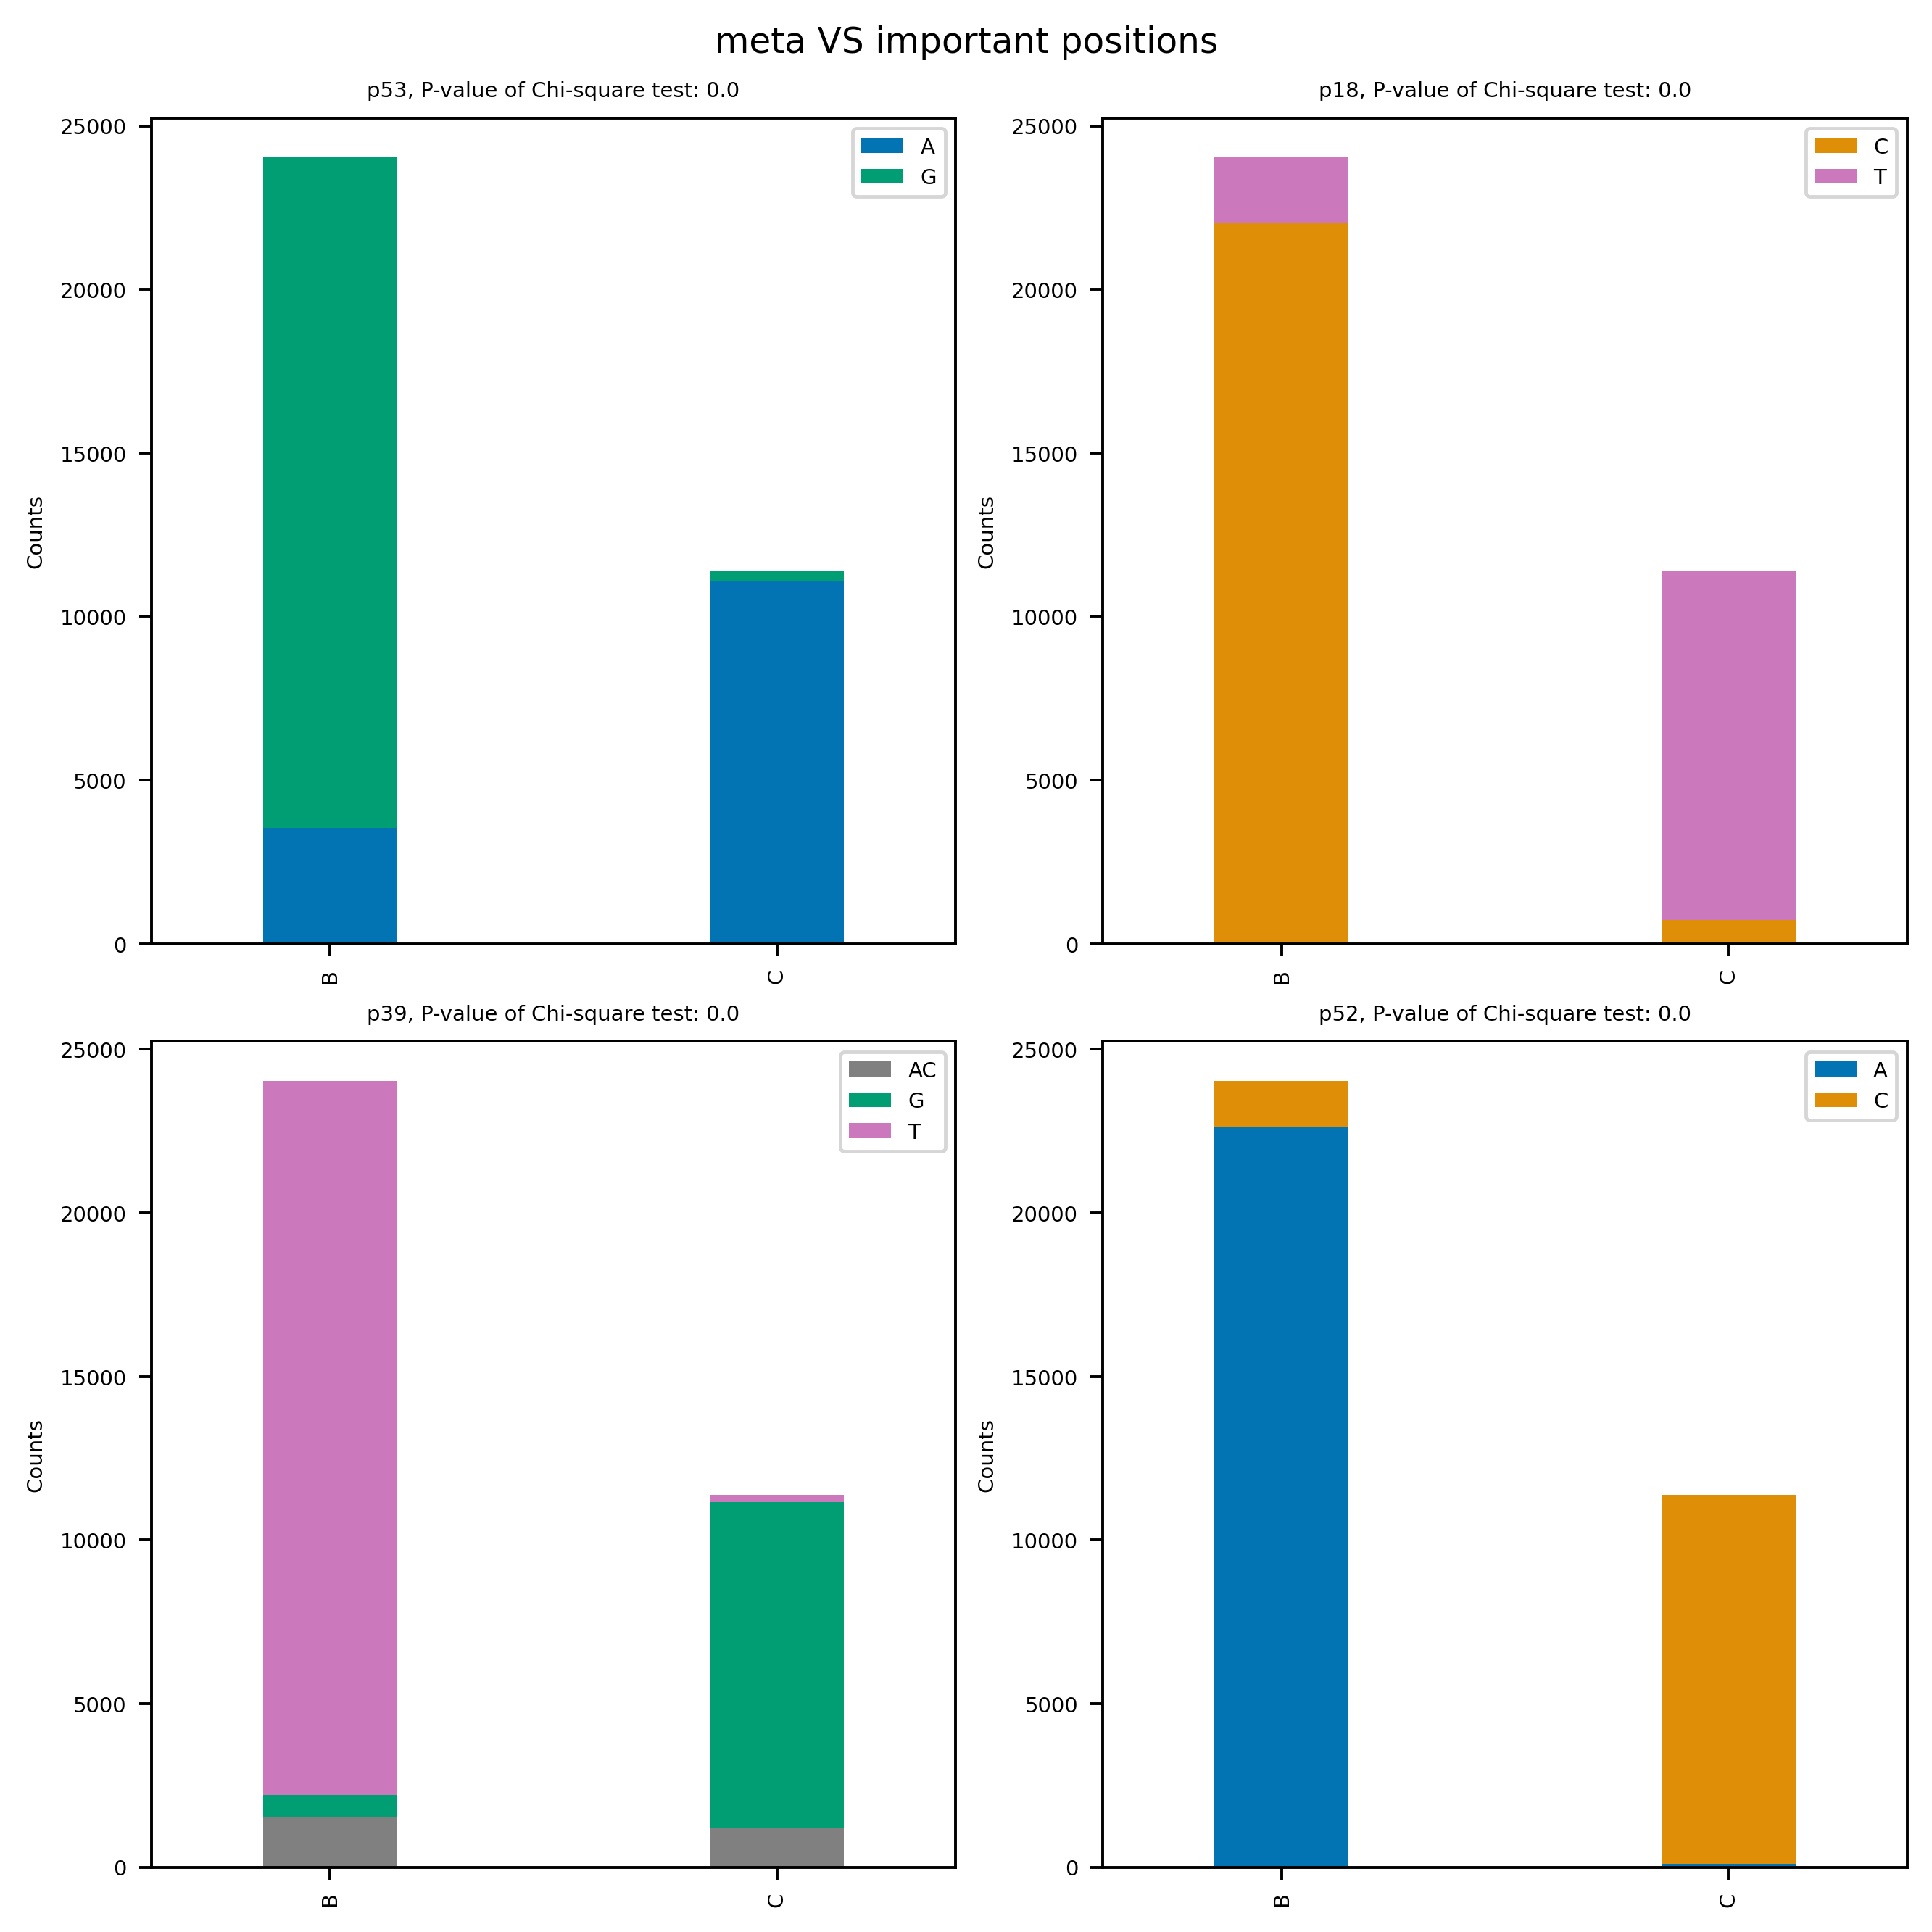

In [27]:
for model in top:
    model_name = model.steps[-1][0]
    dp_plot(importance=importance_from_pipe(model),
            imp_col='standard_value',
            model_name = model_name, report_dir=report_dir)
    
    plot_imp_model(importance=importance_from_pipe(model), 
               X_train=tr, y_train=y, model_name=model_name,
                   meta_var='meta', model_type=ana_type, report_dir=report_dir)

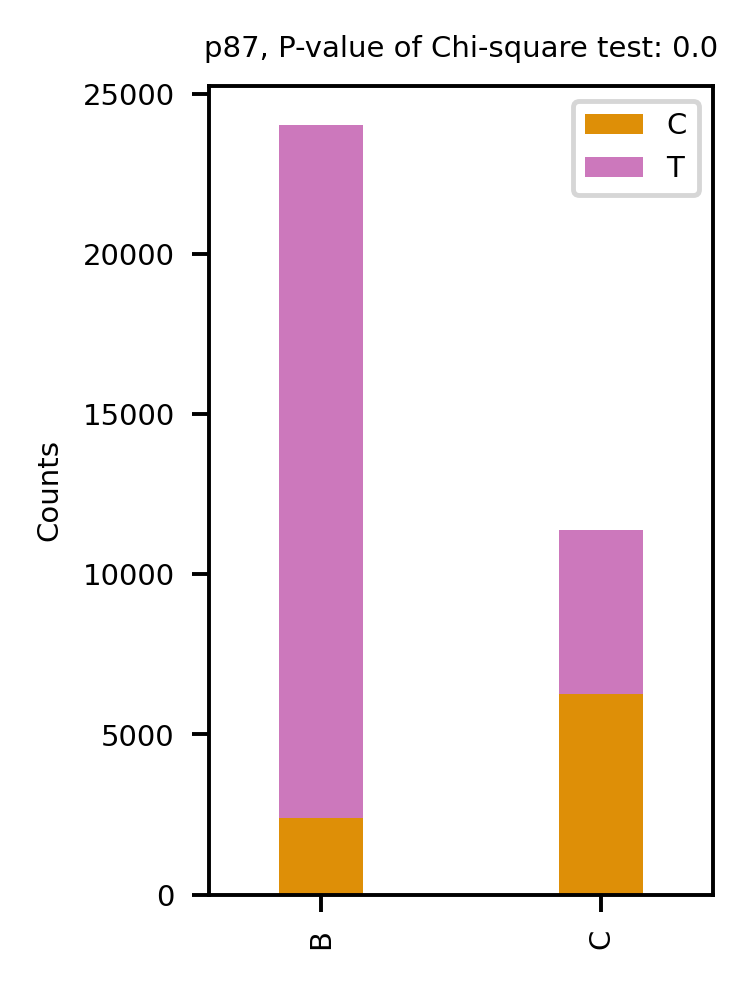

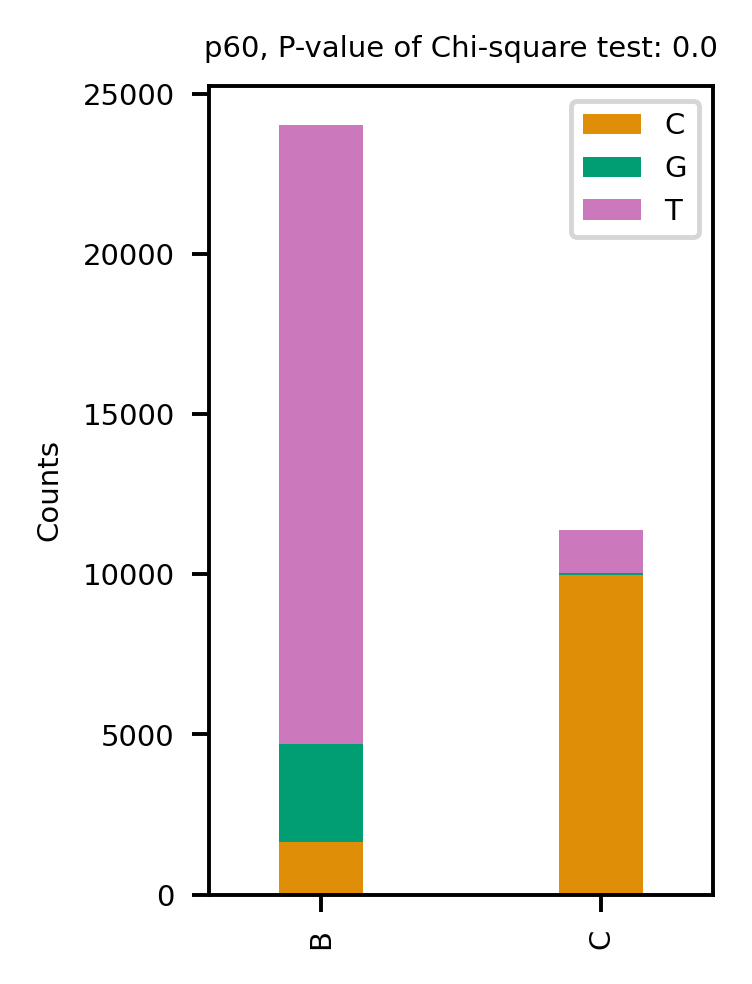

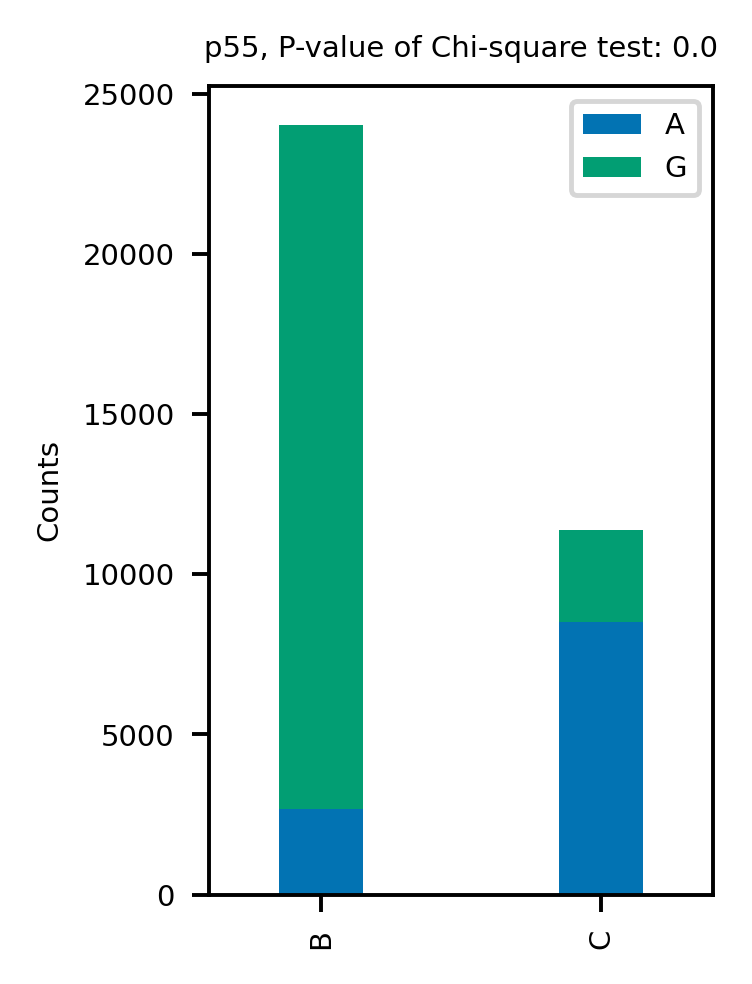

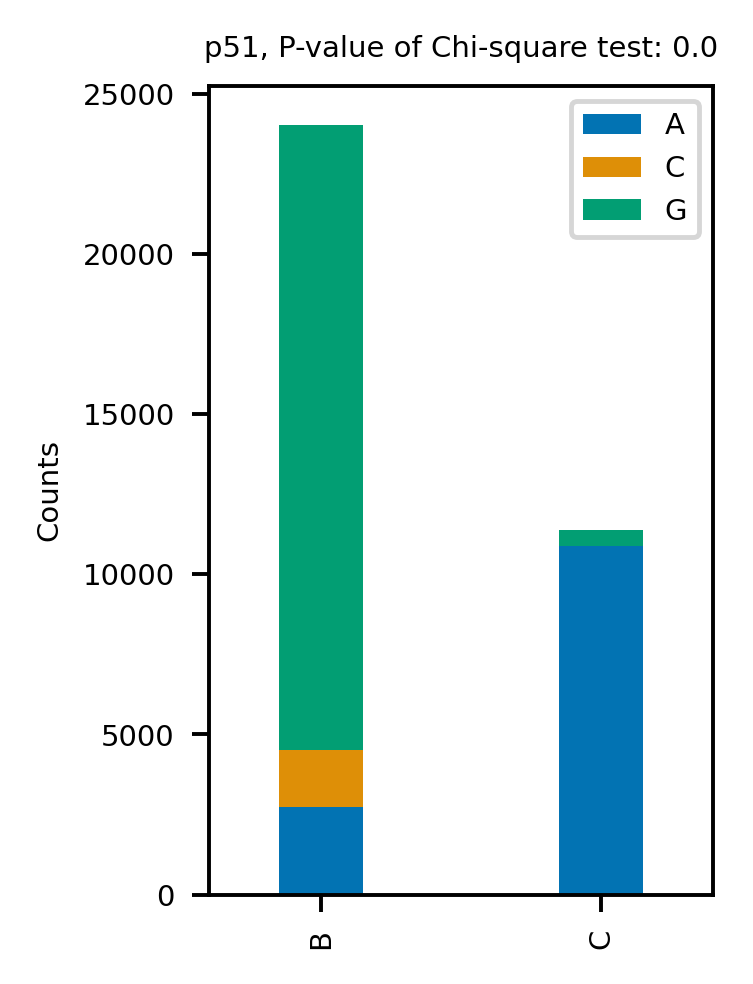

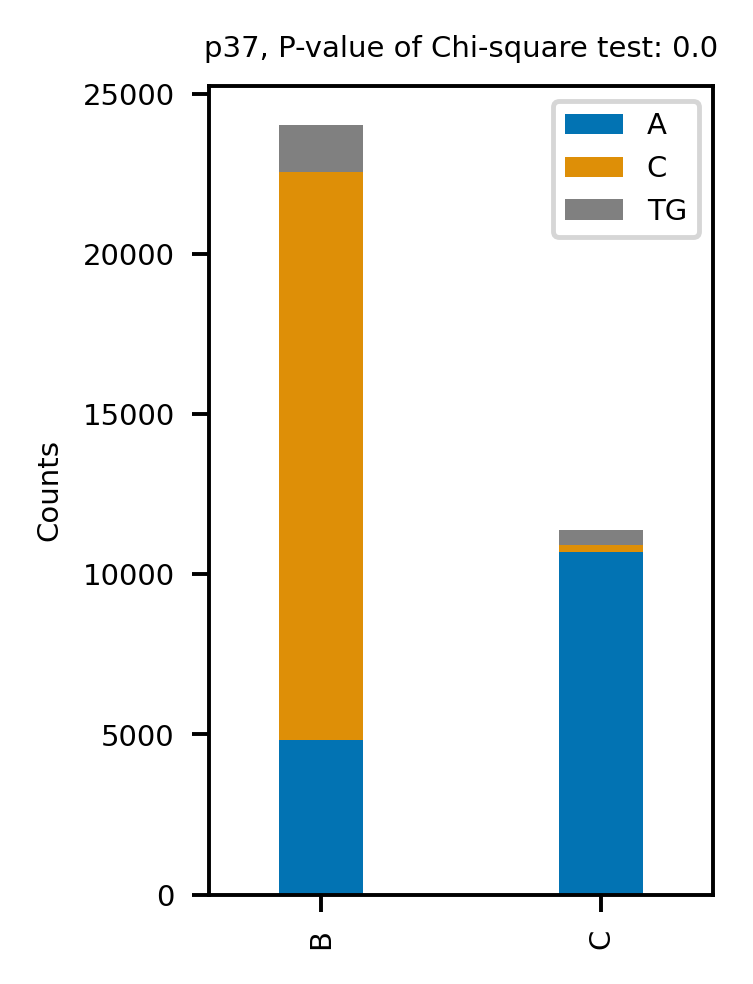

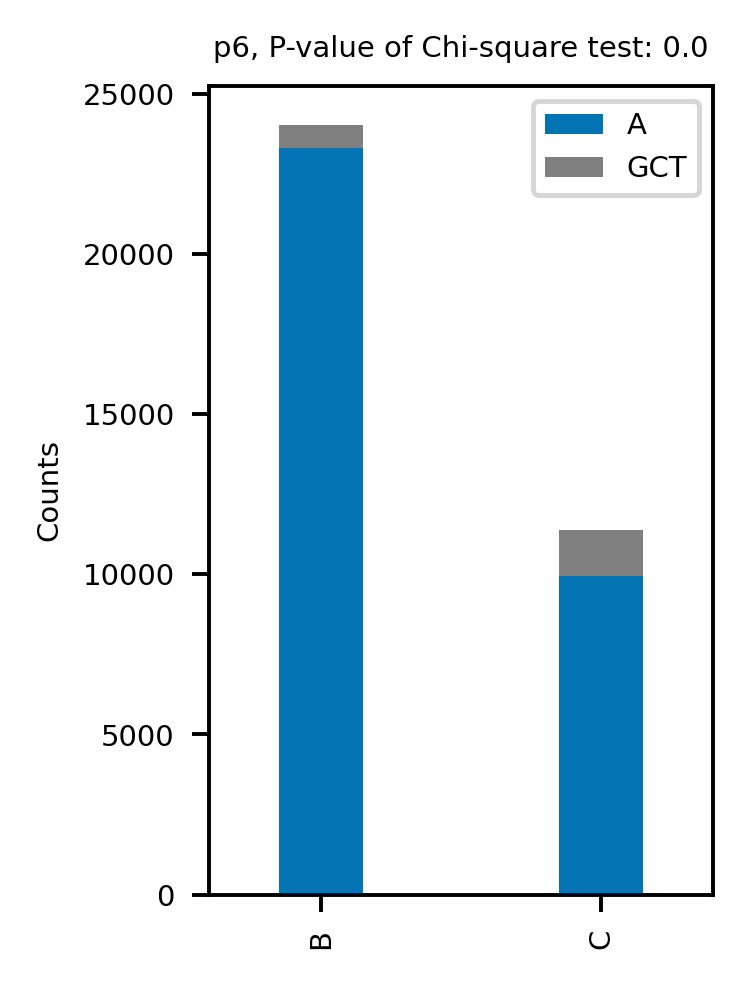

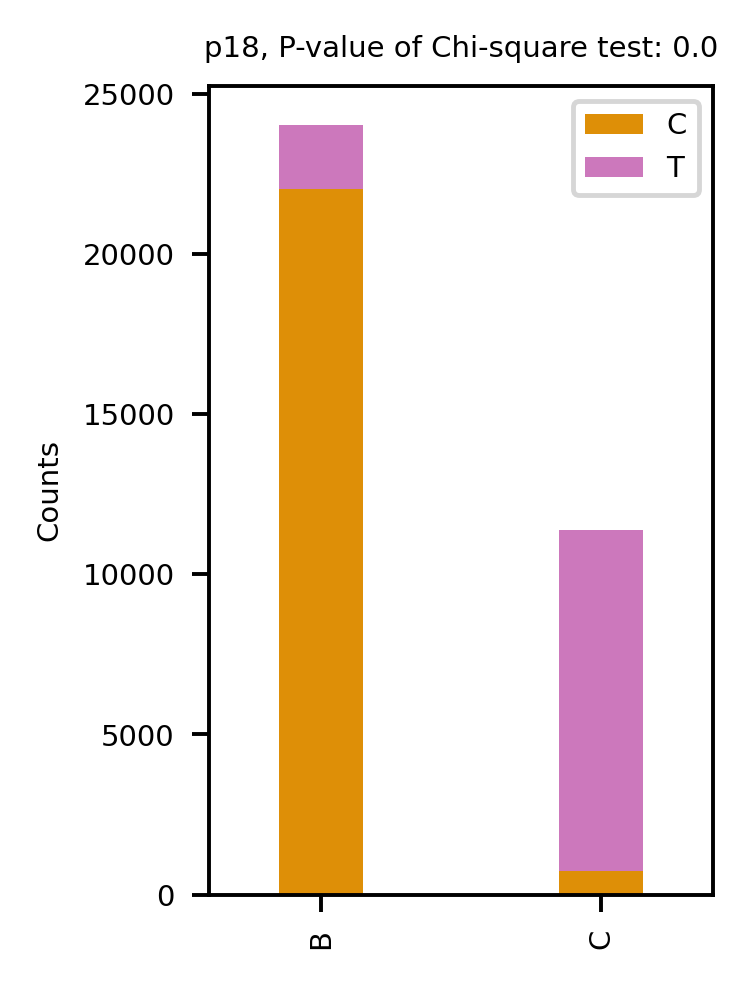

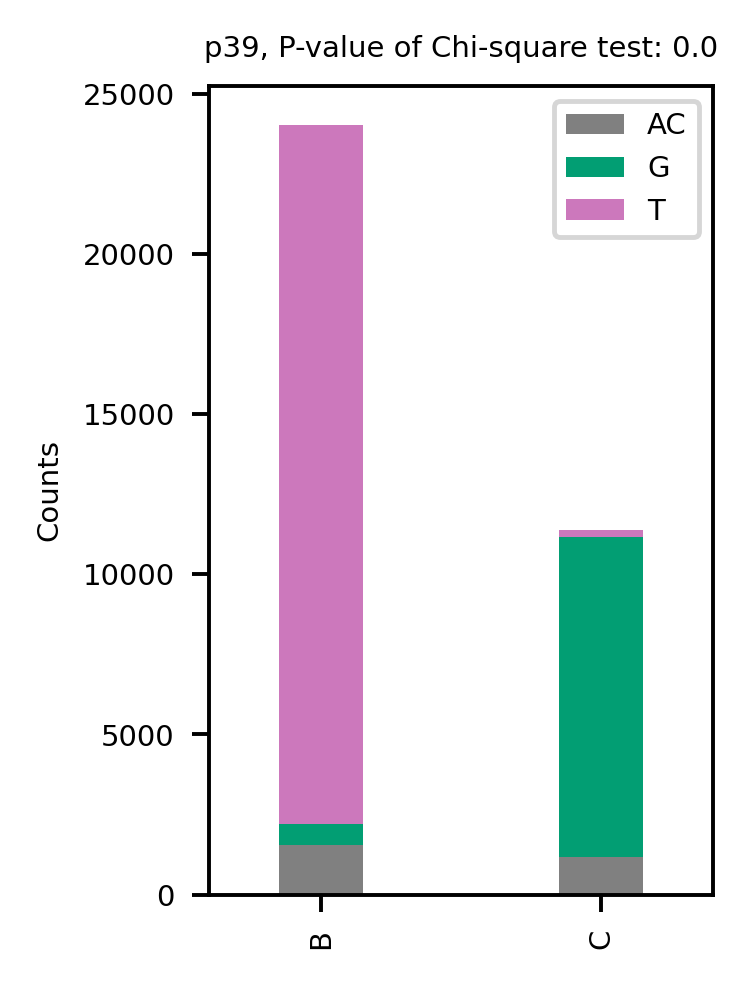

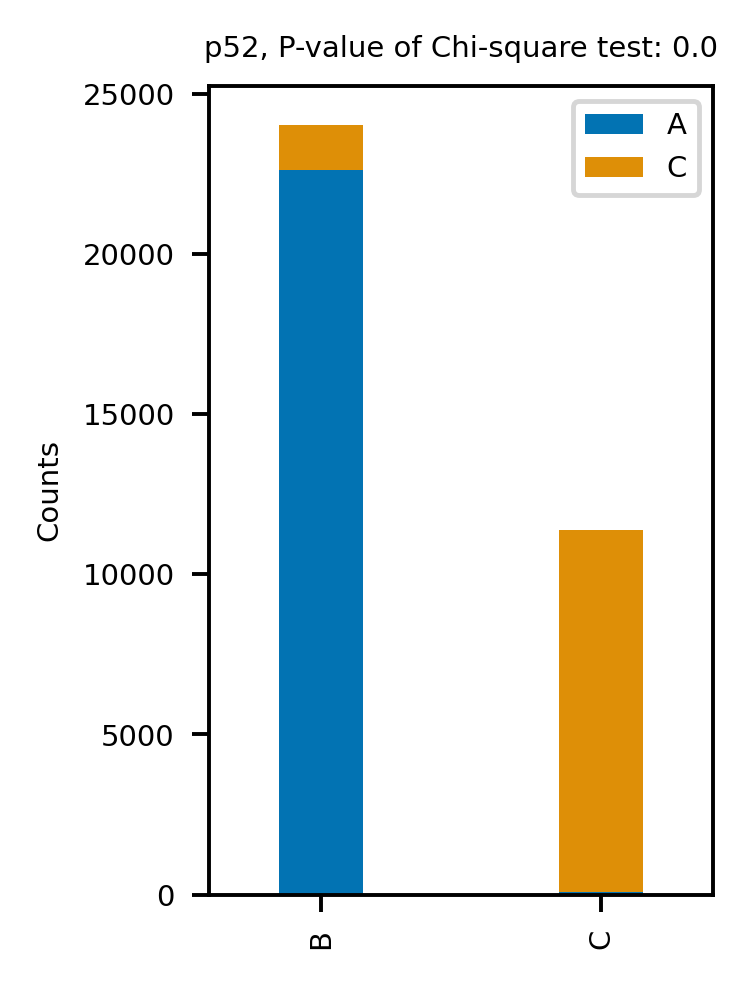

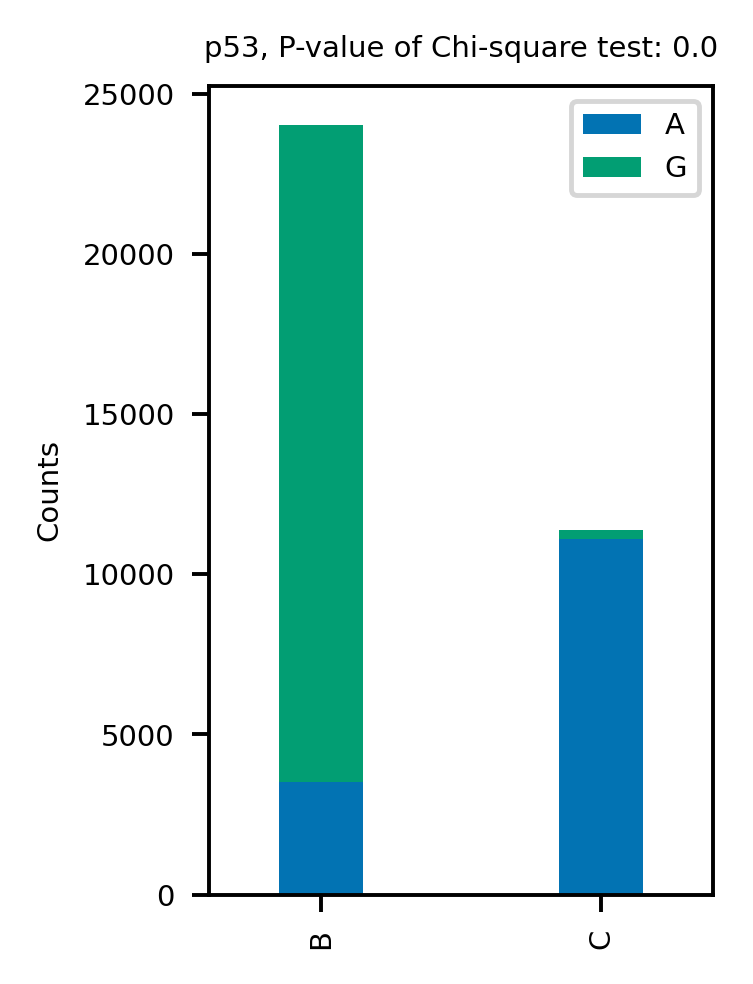

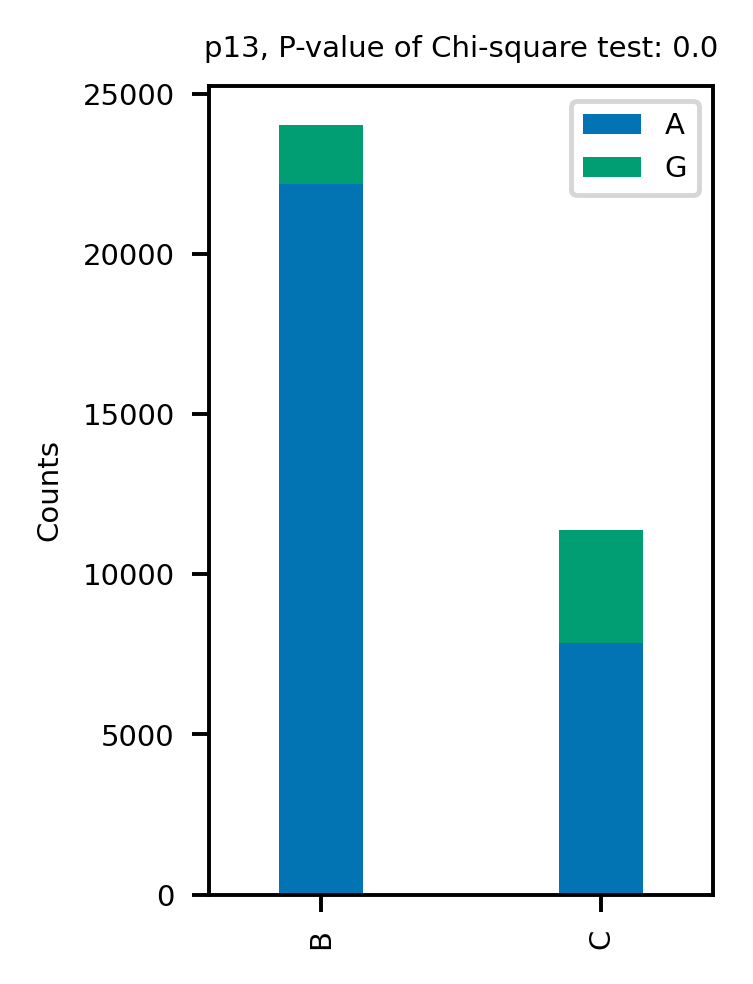

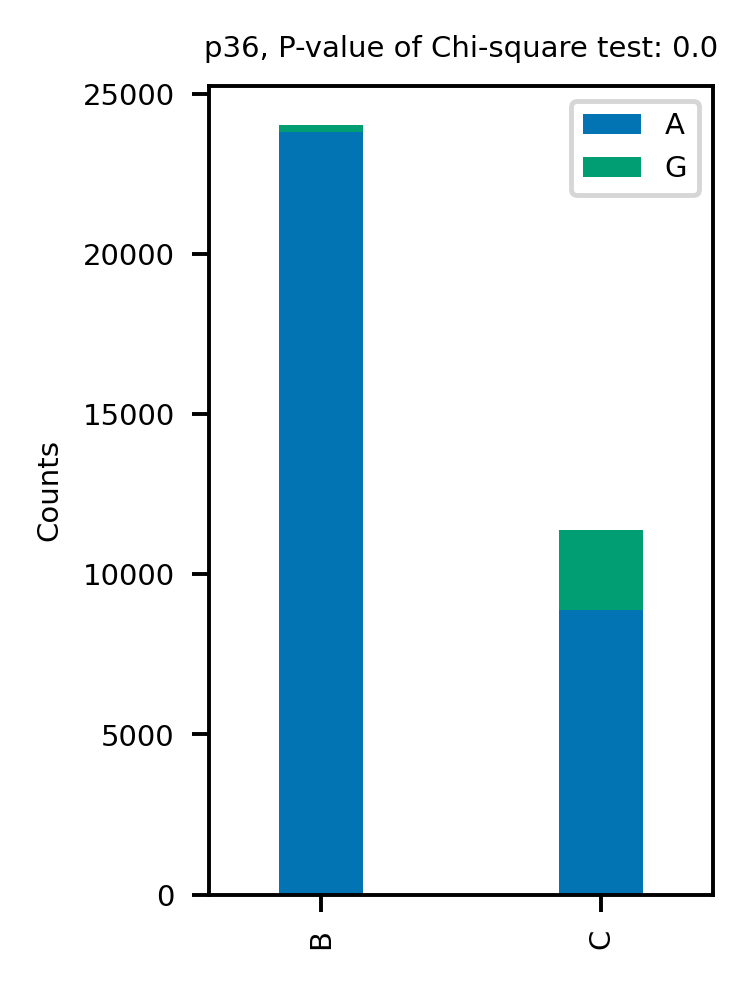

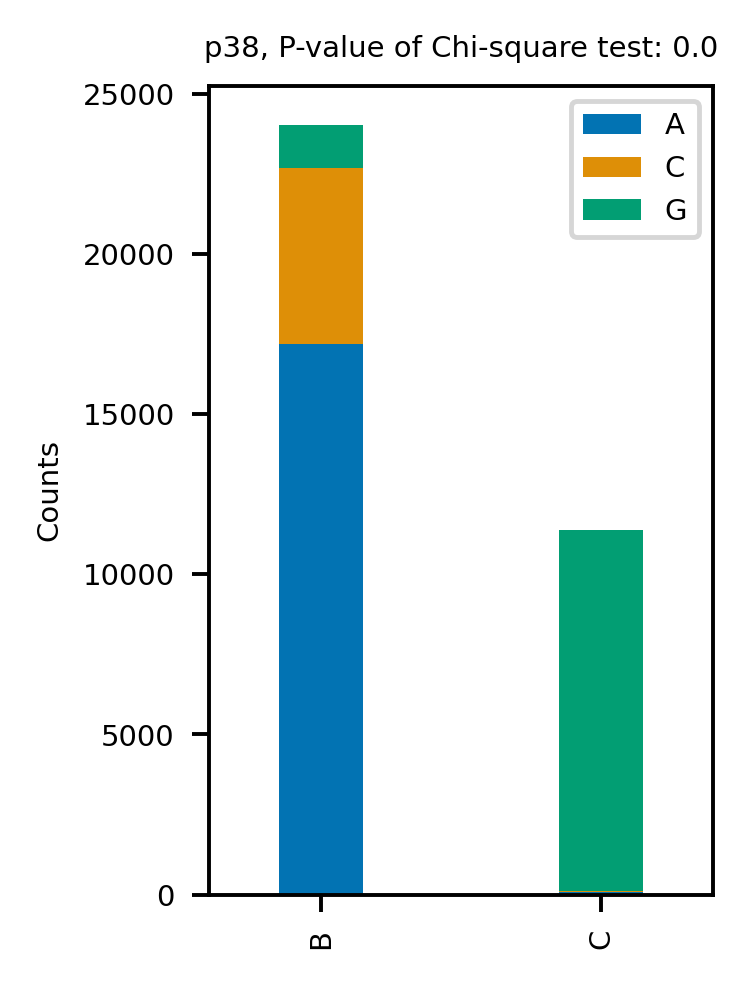

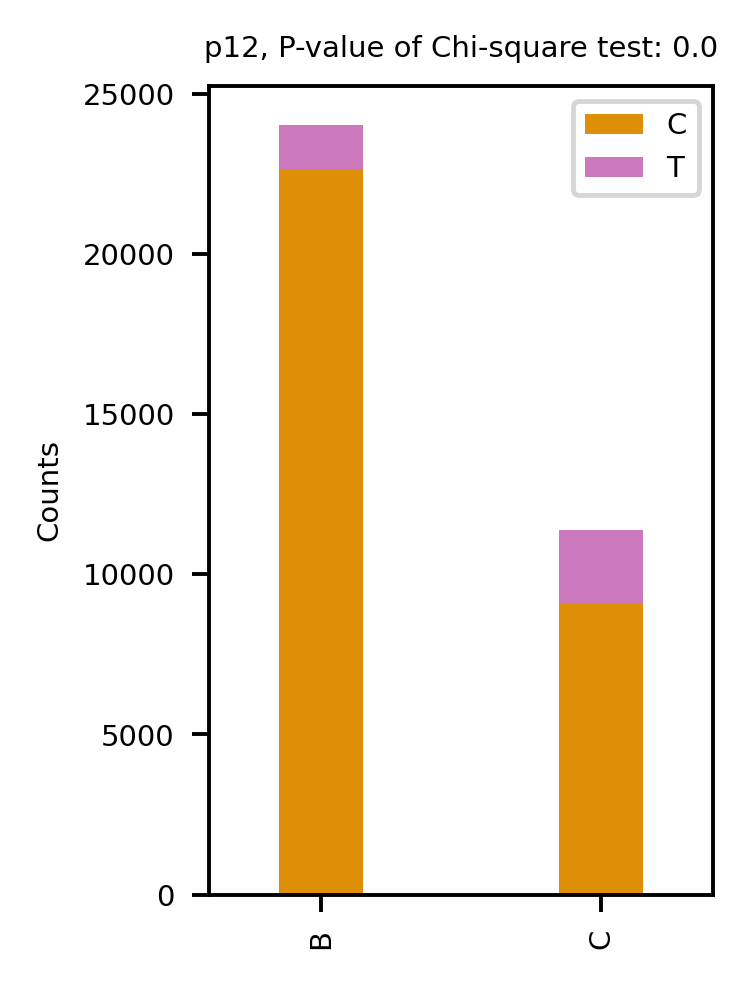

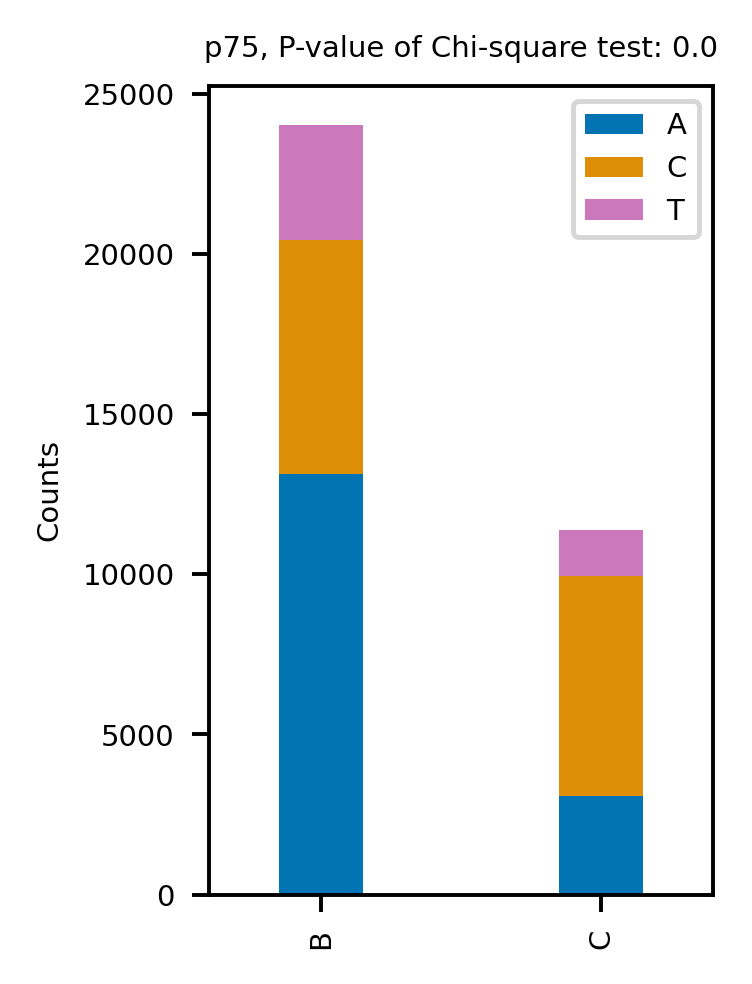

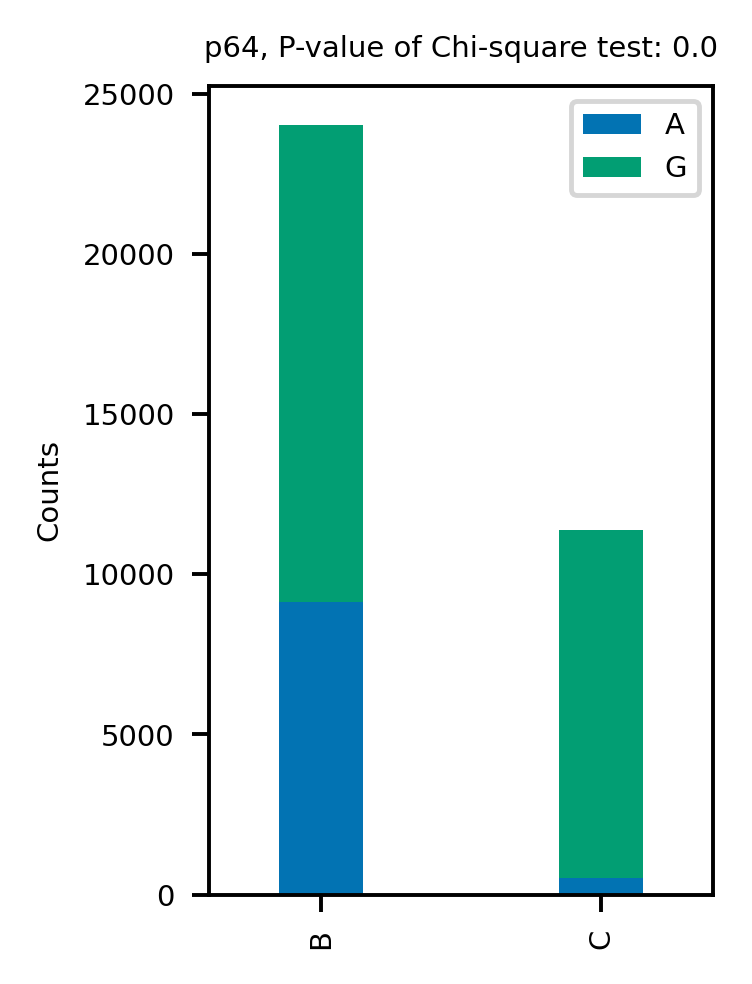

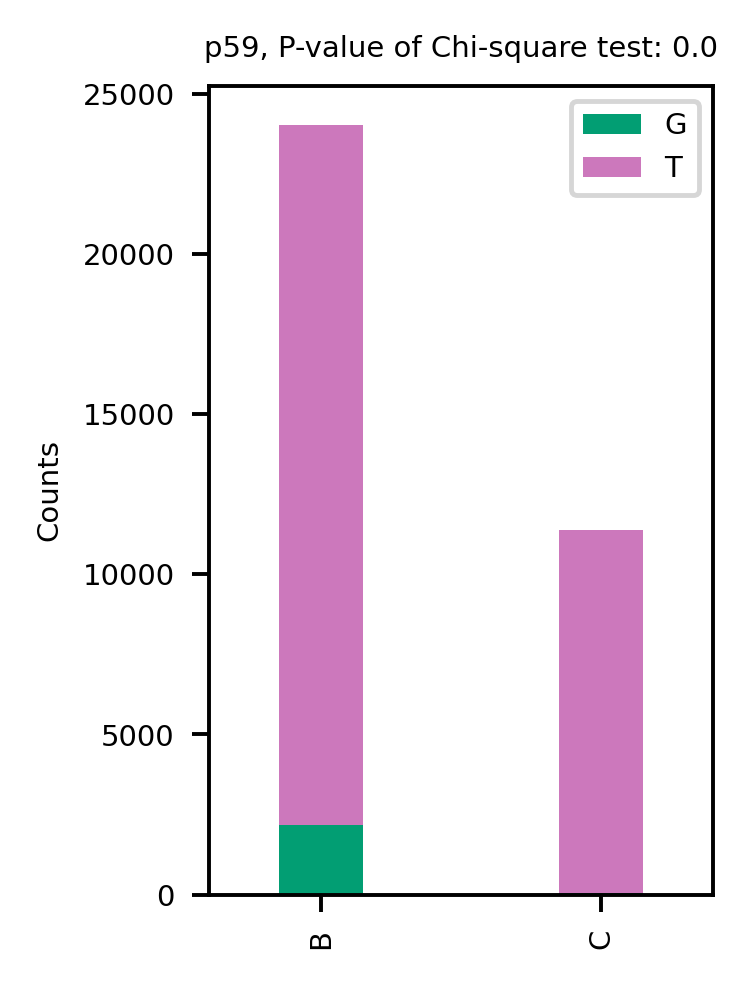

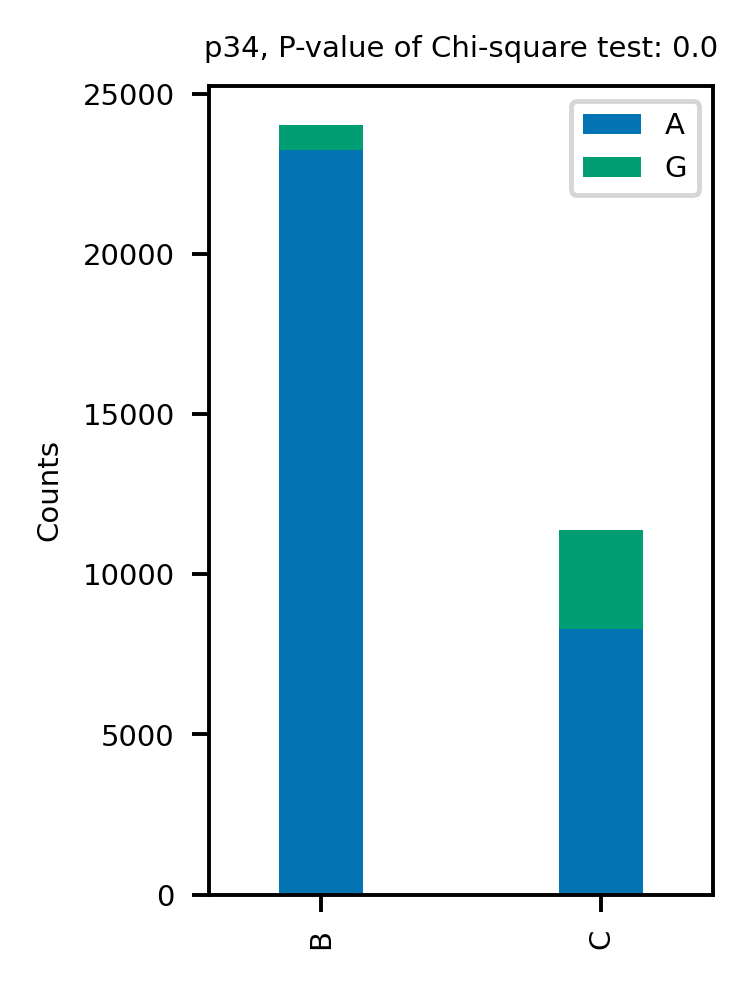

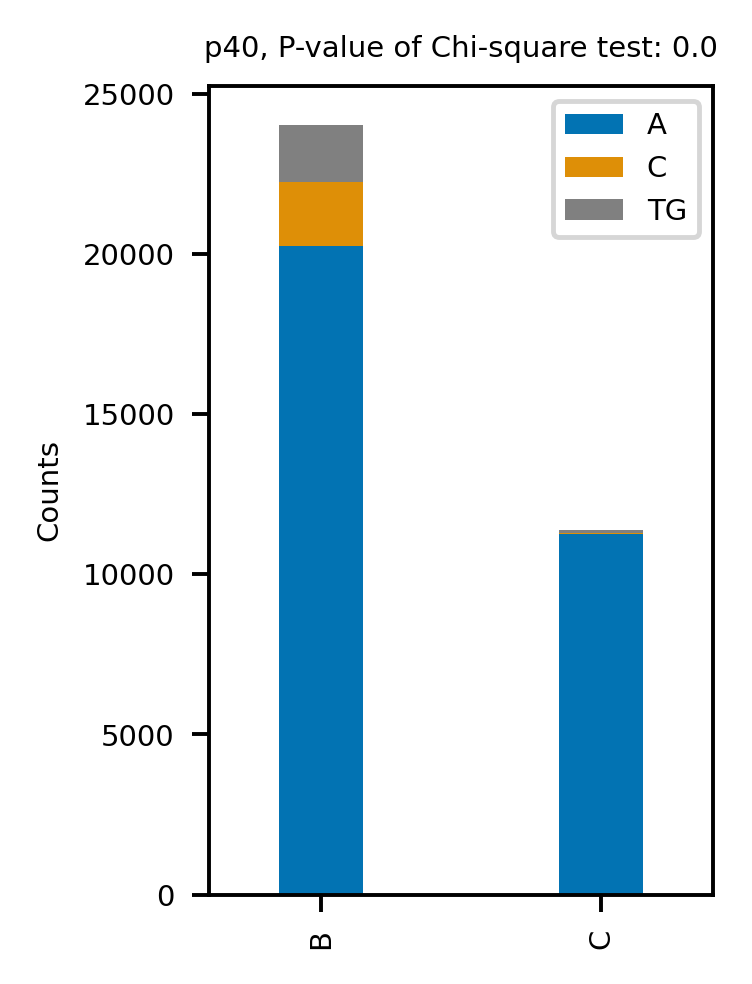

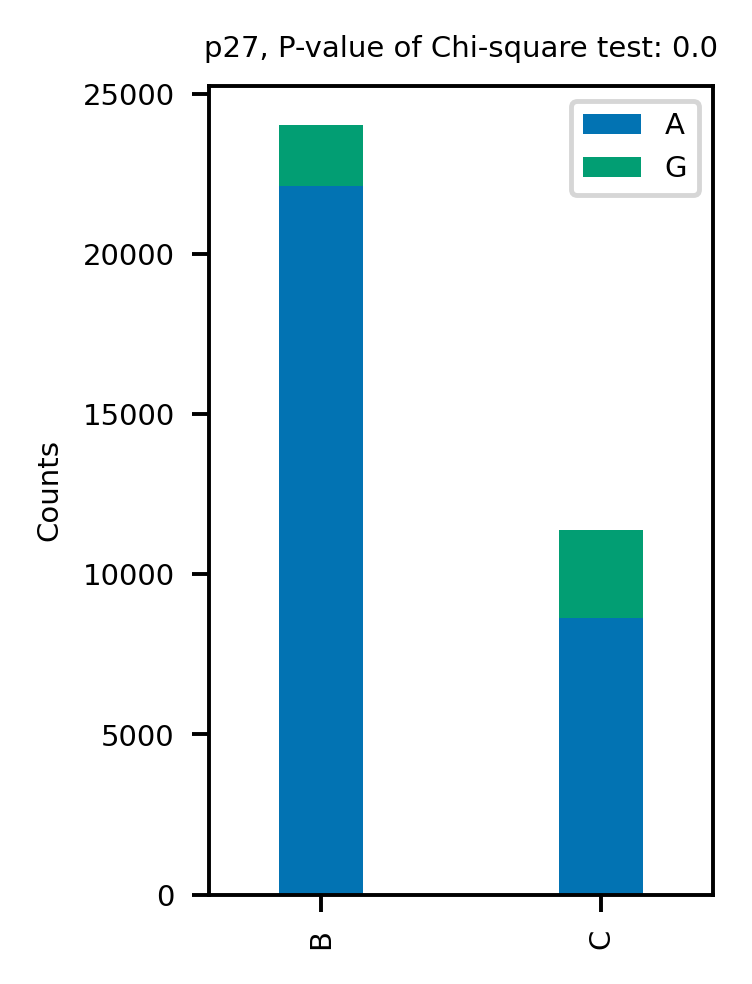

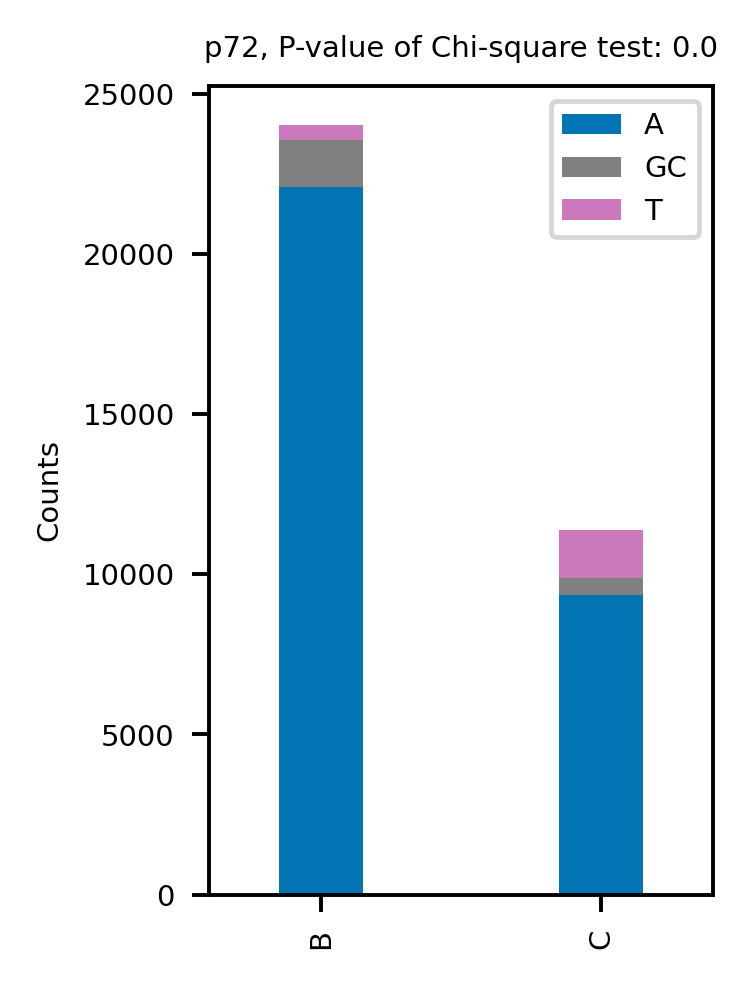

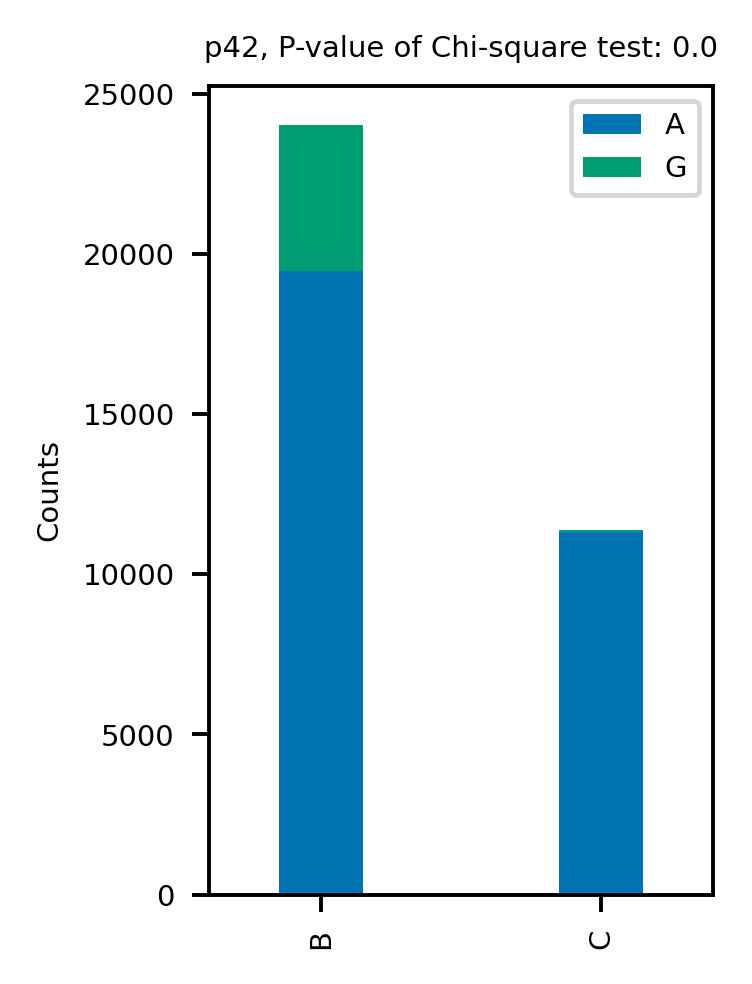

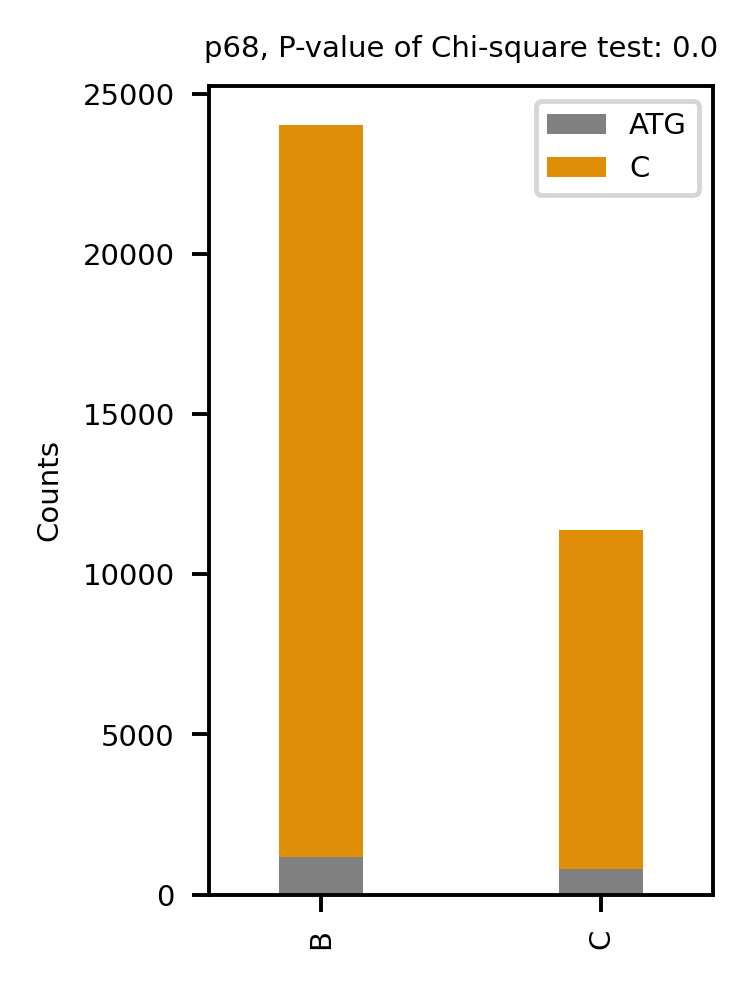

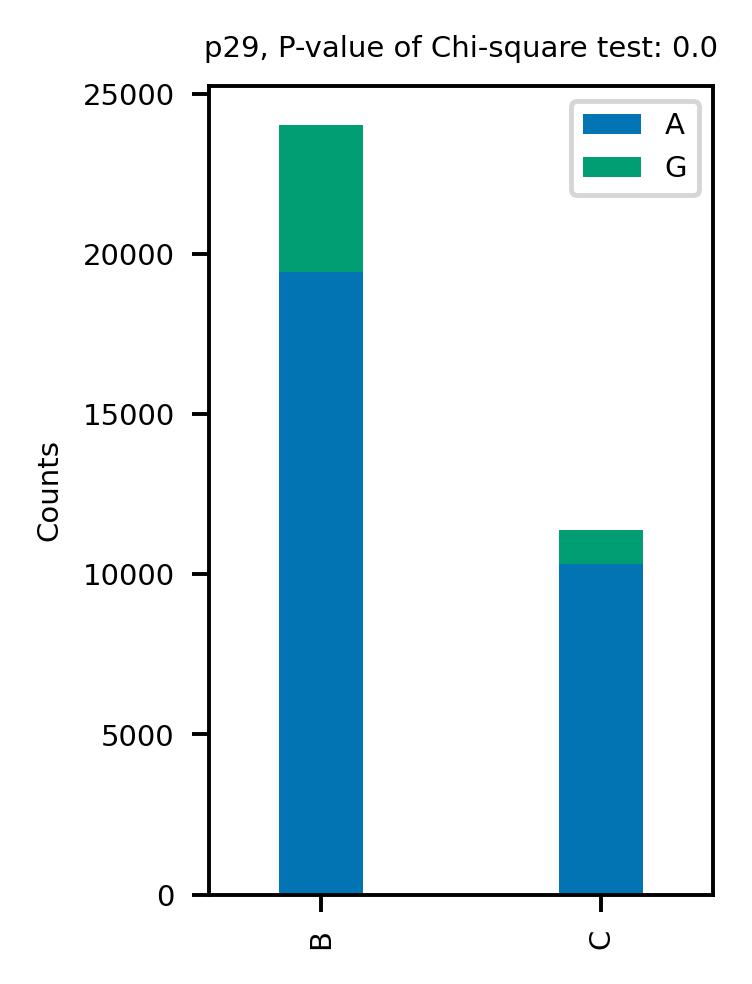

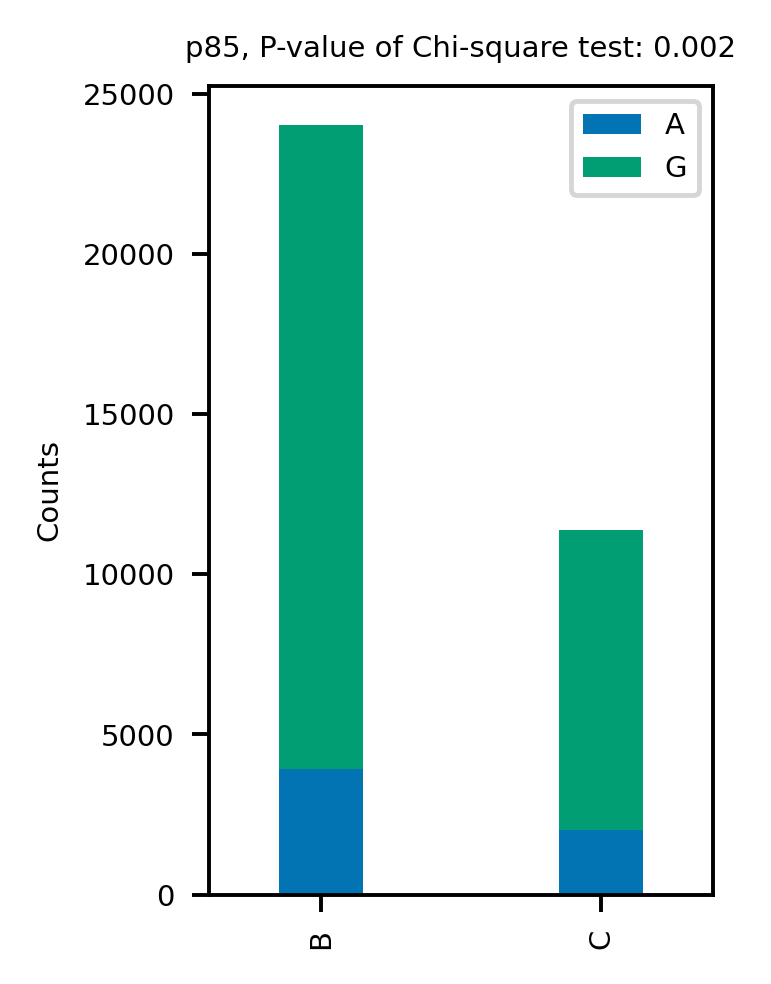

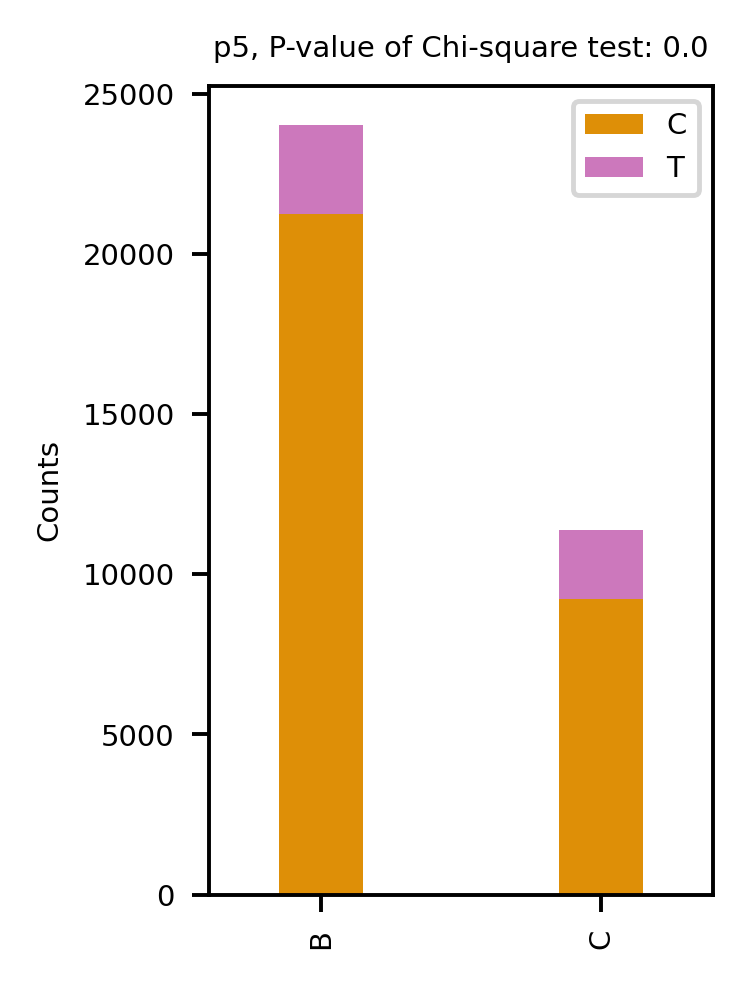

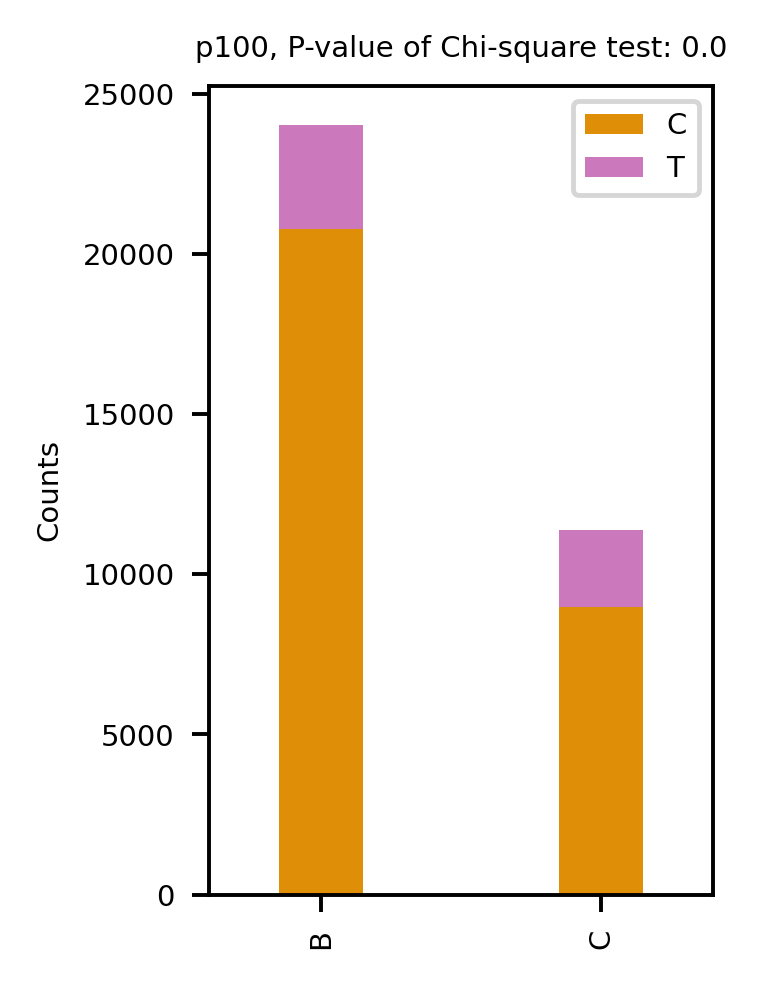

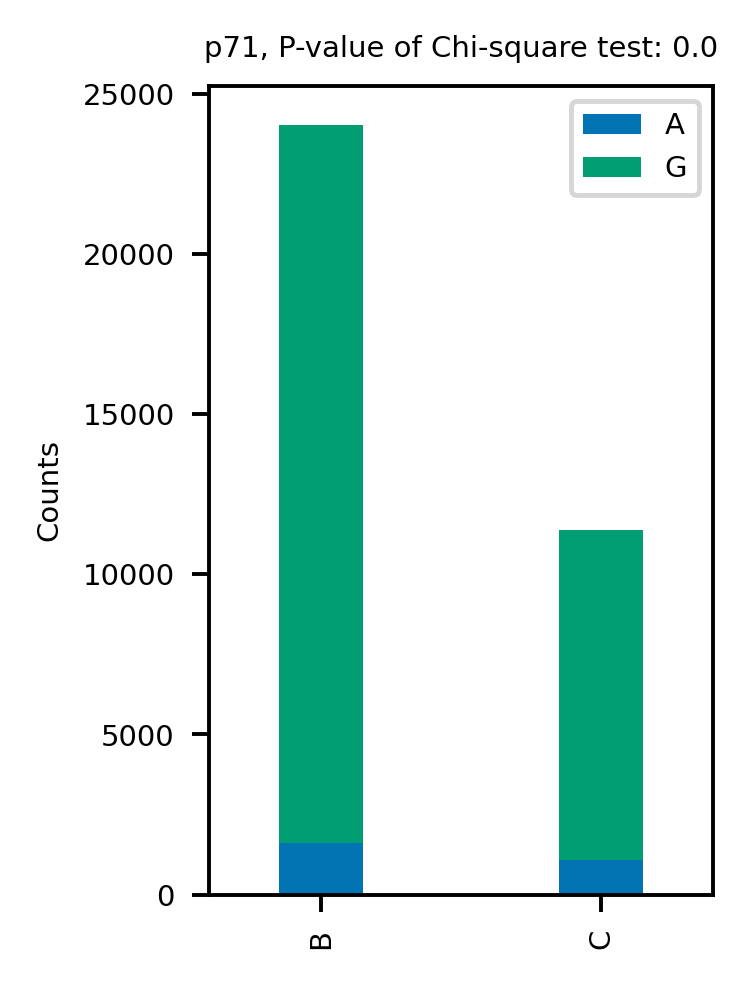

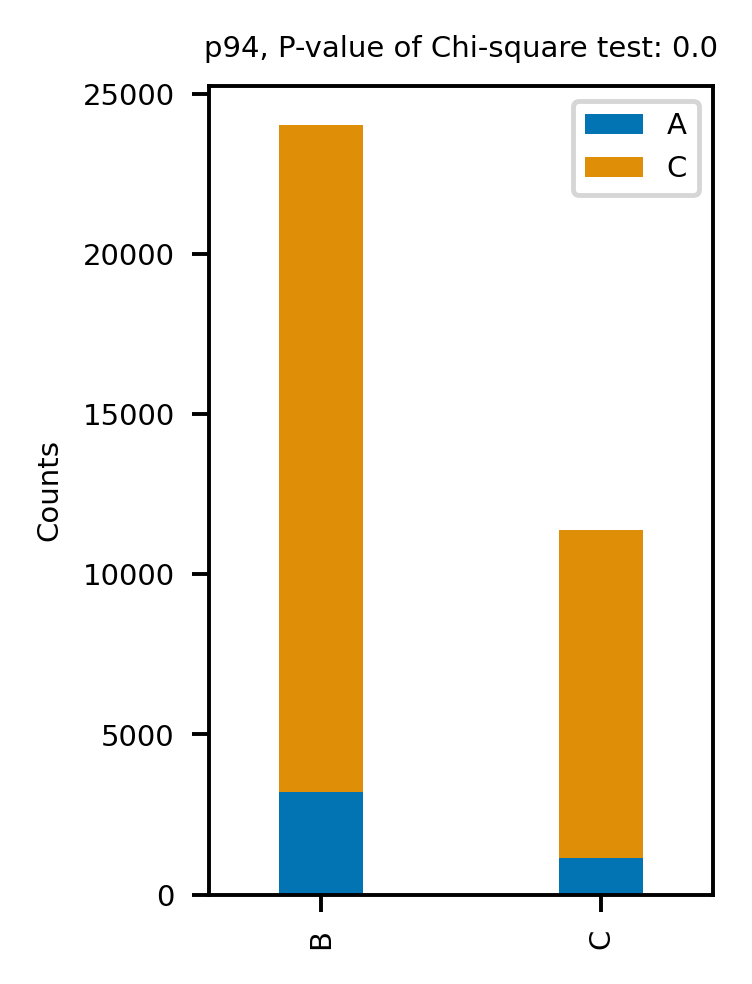

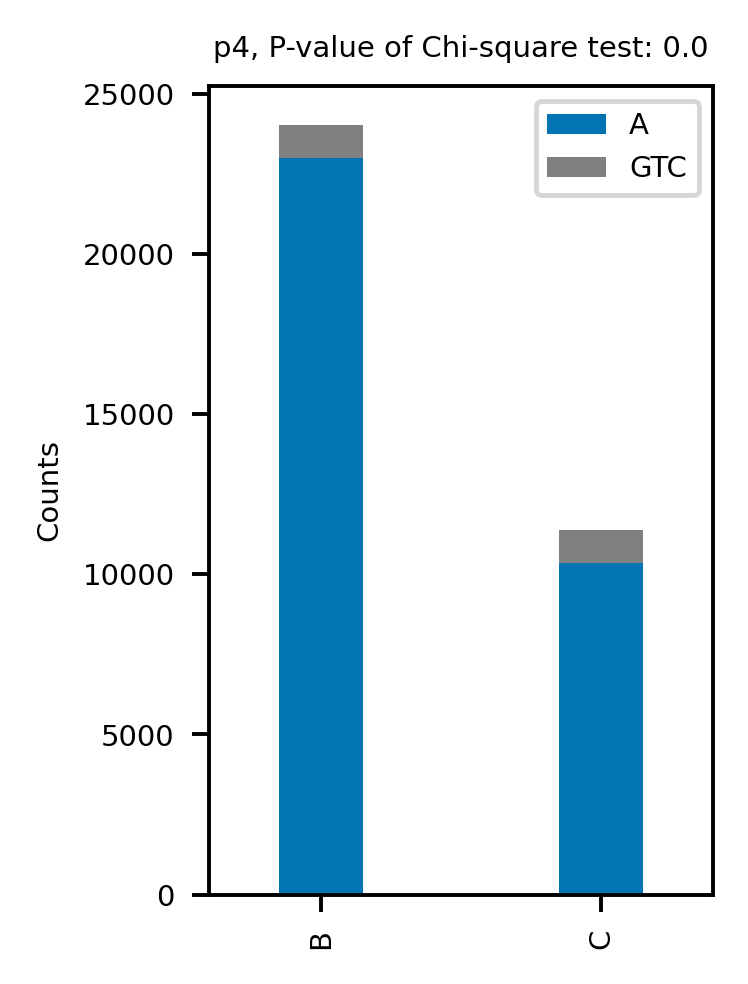

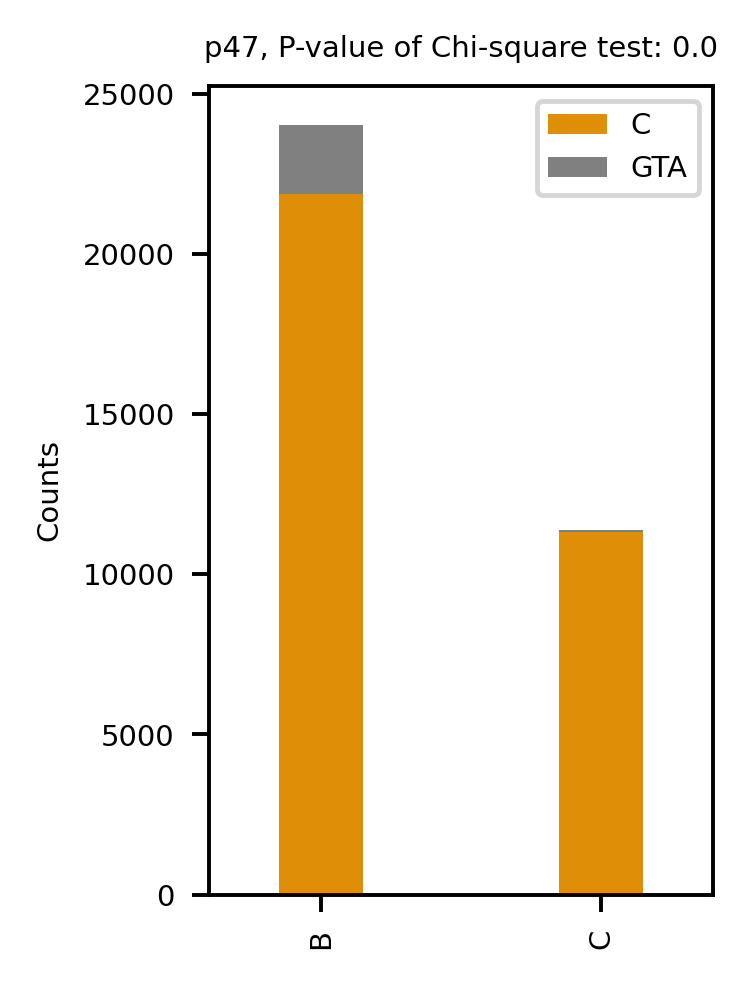

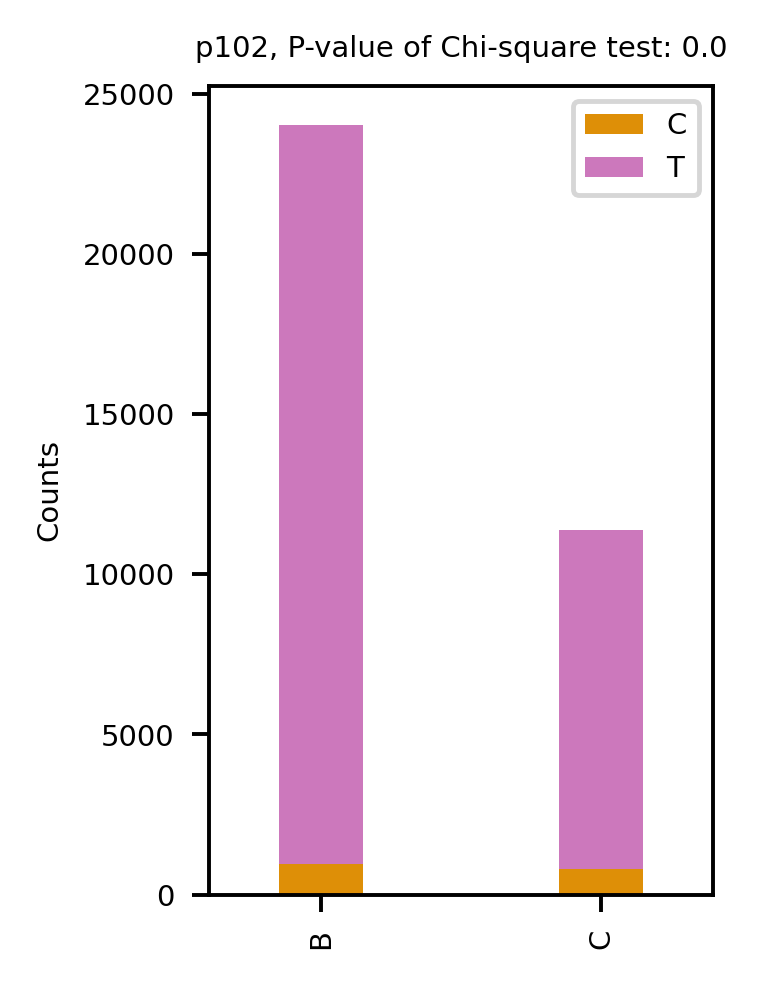

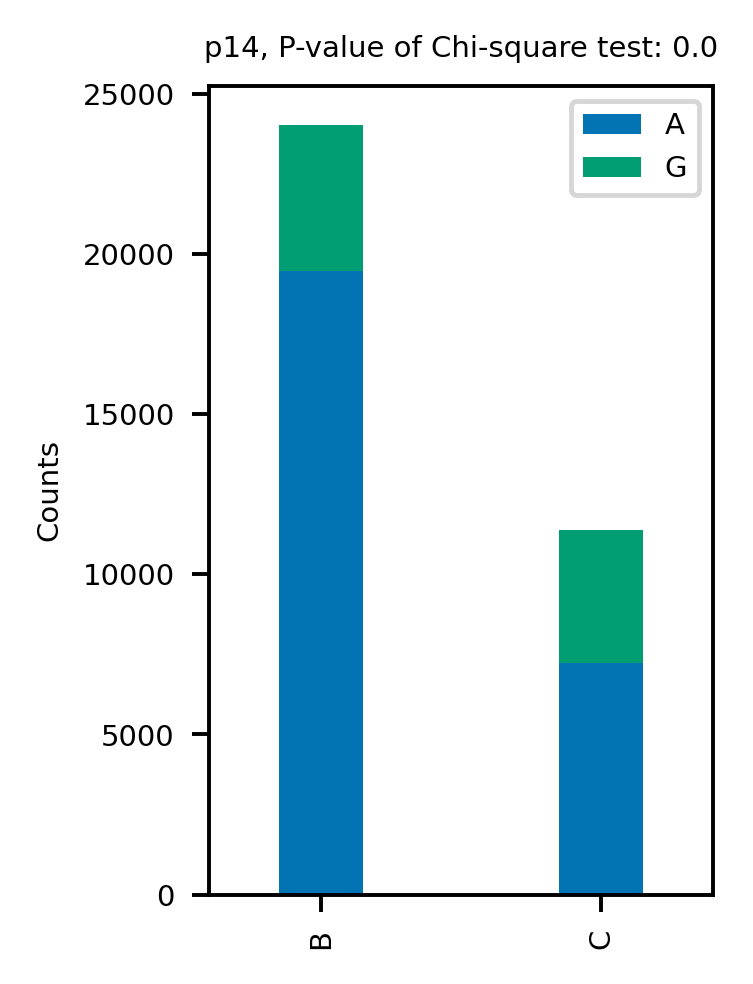

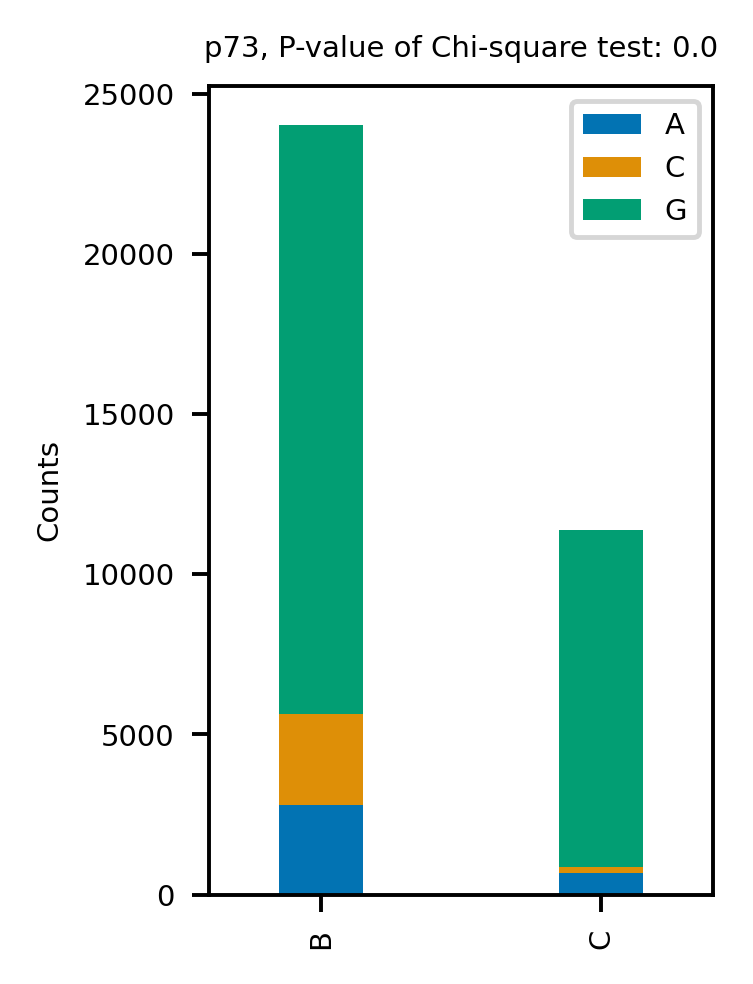

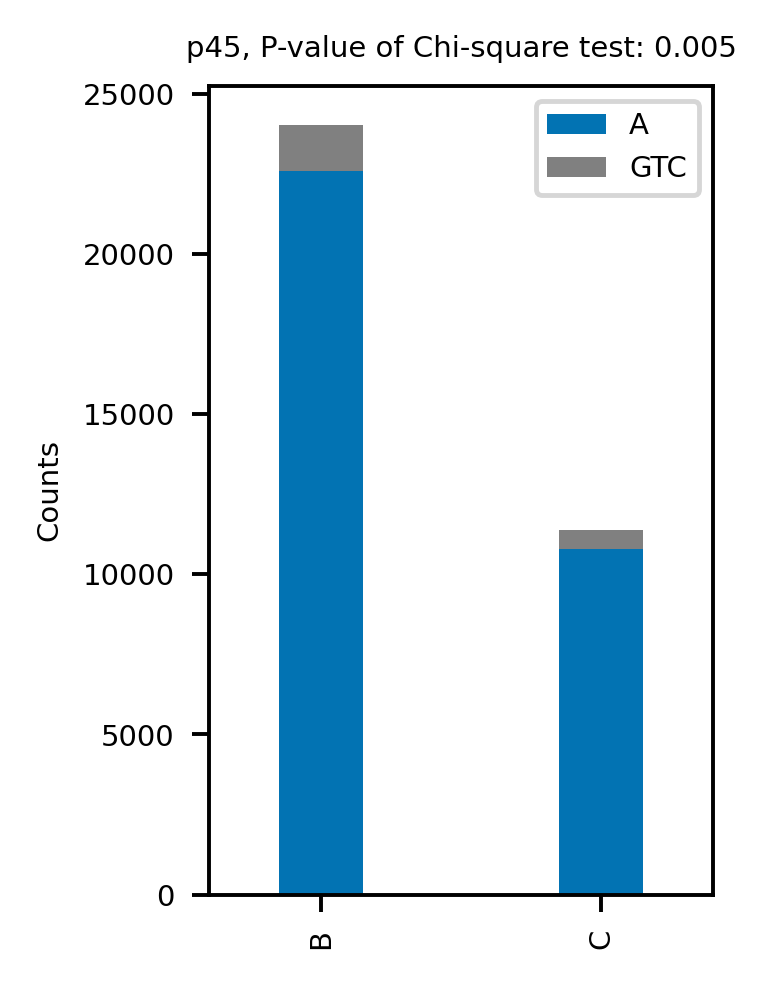

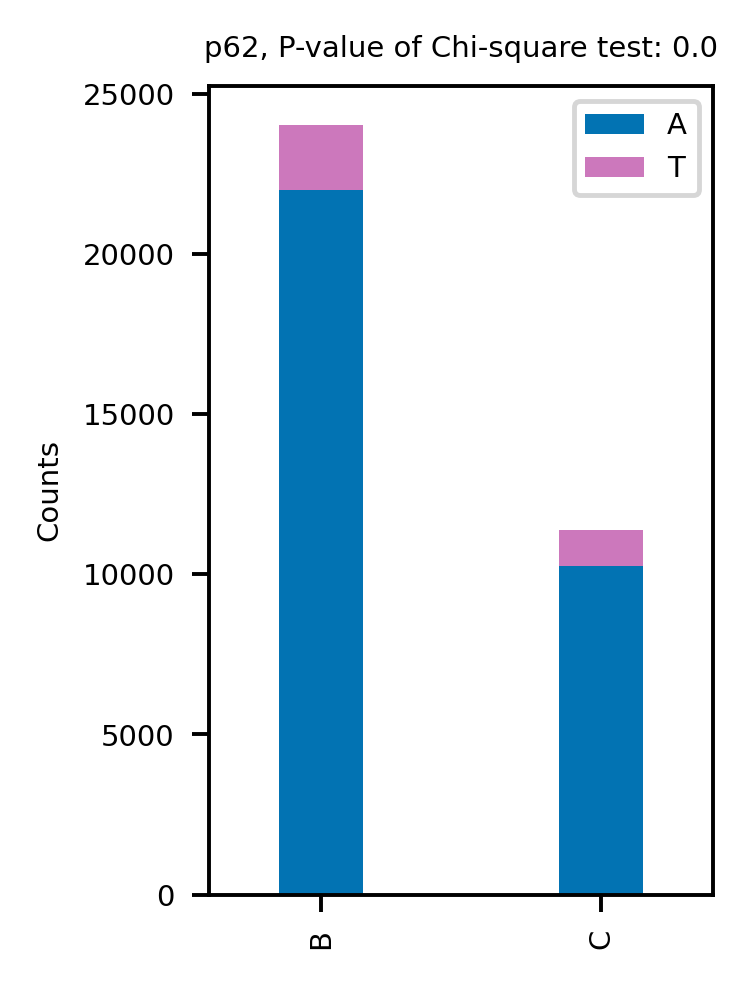

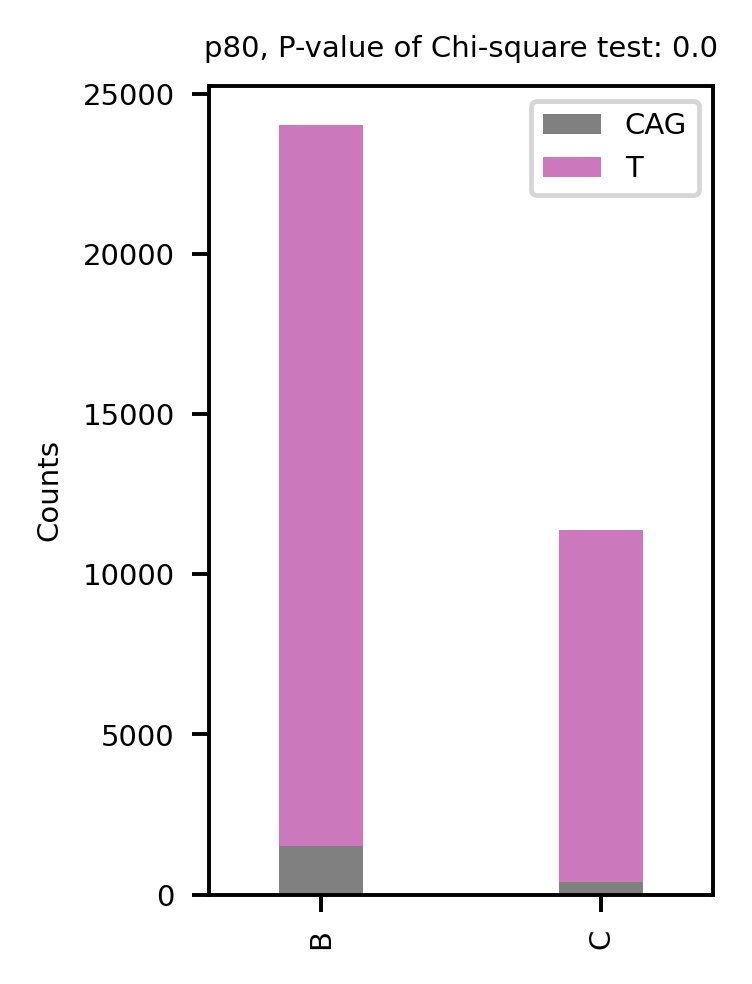

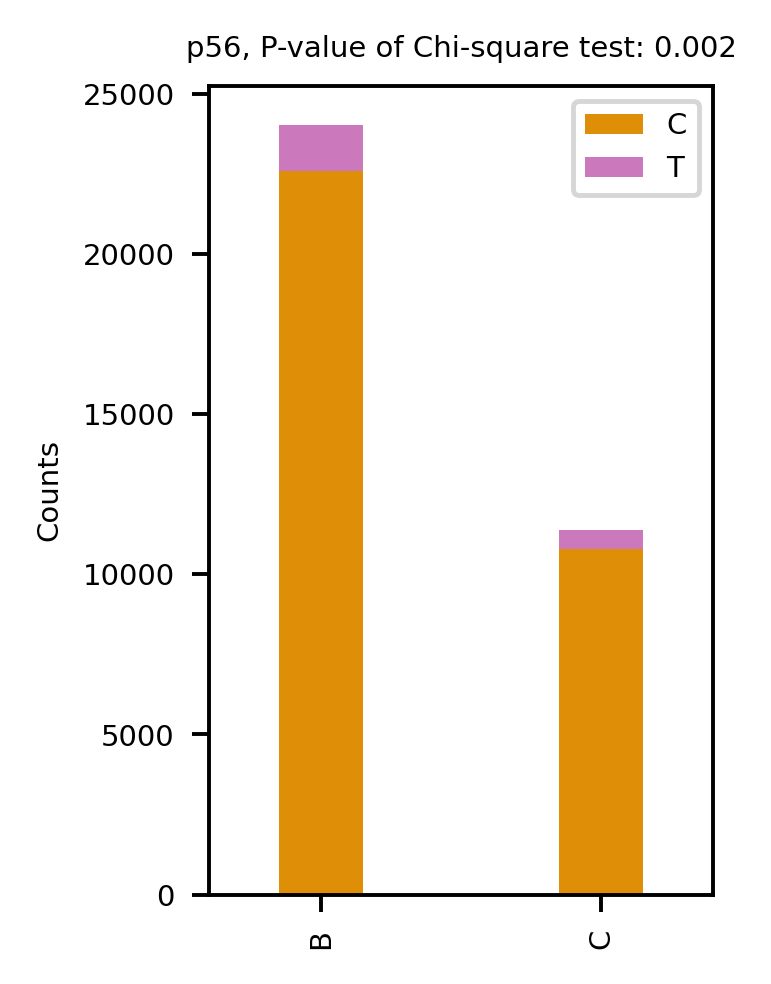

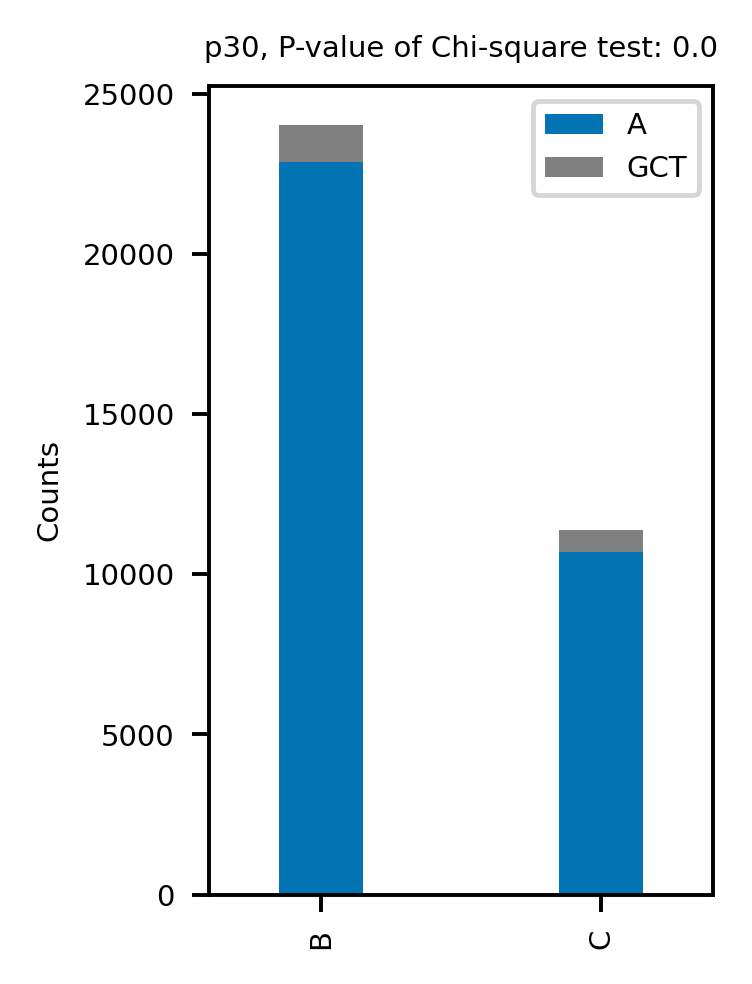

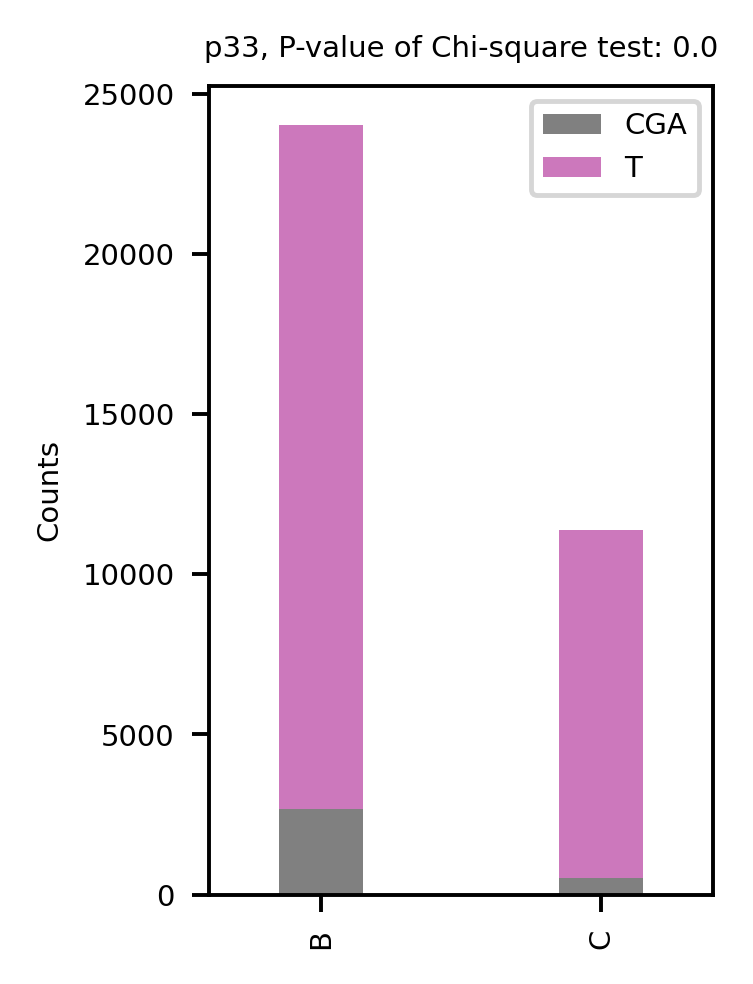

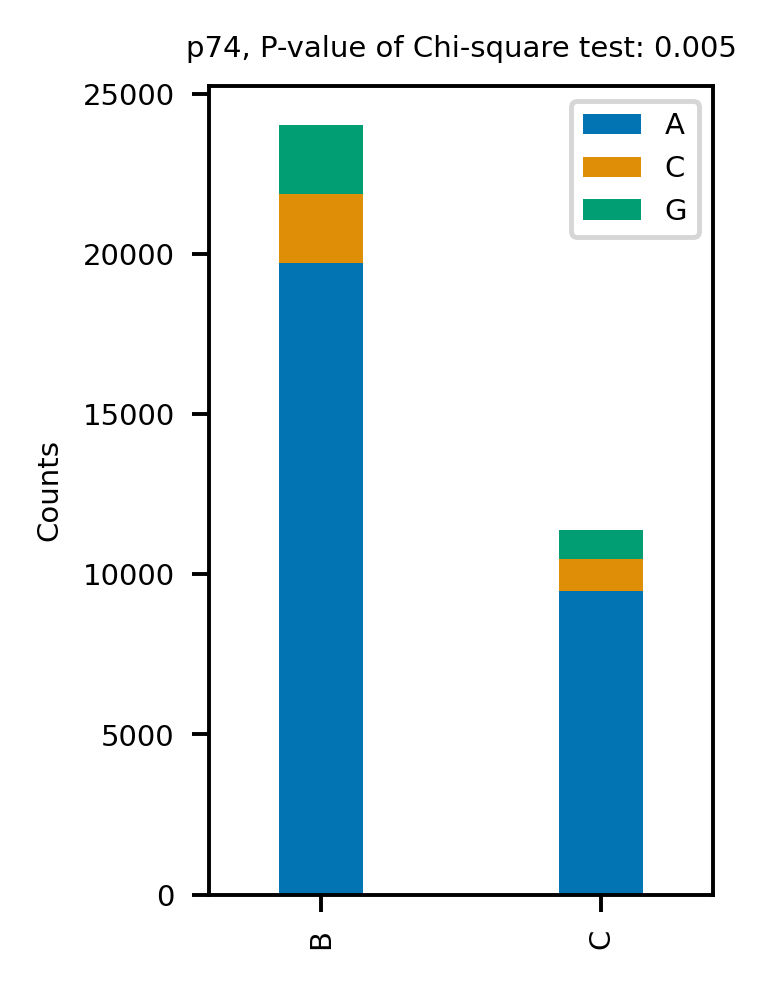

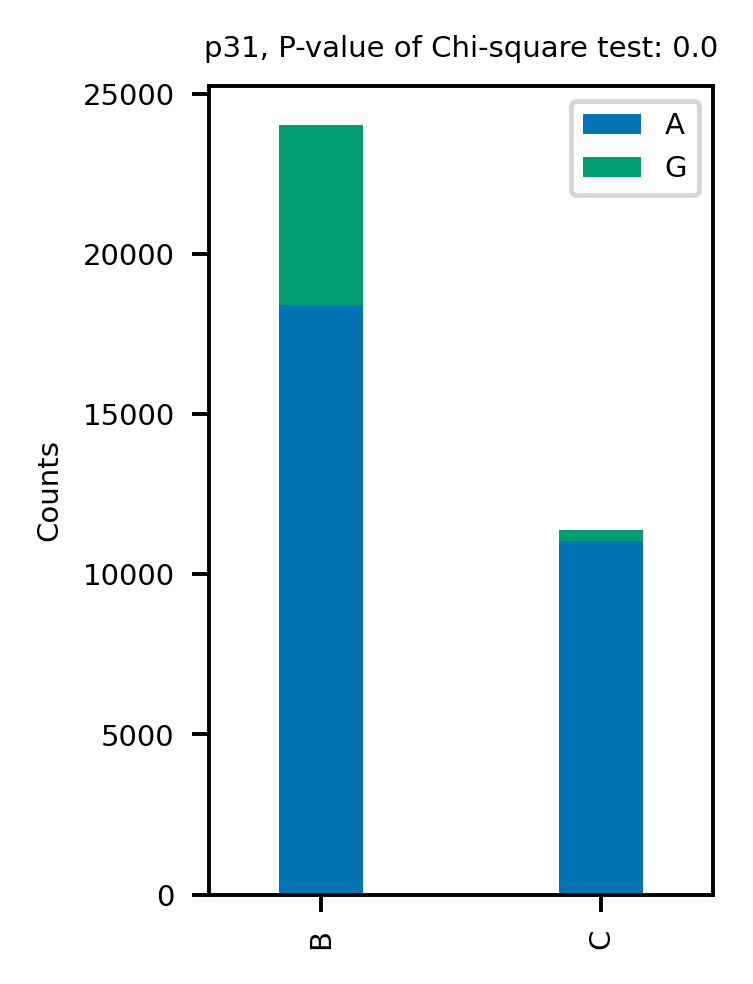

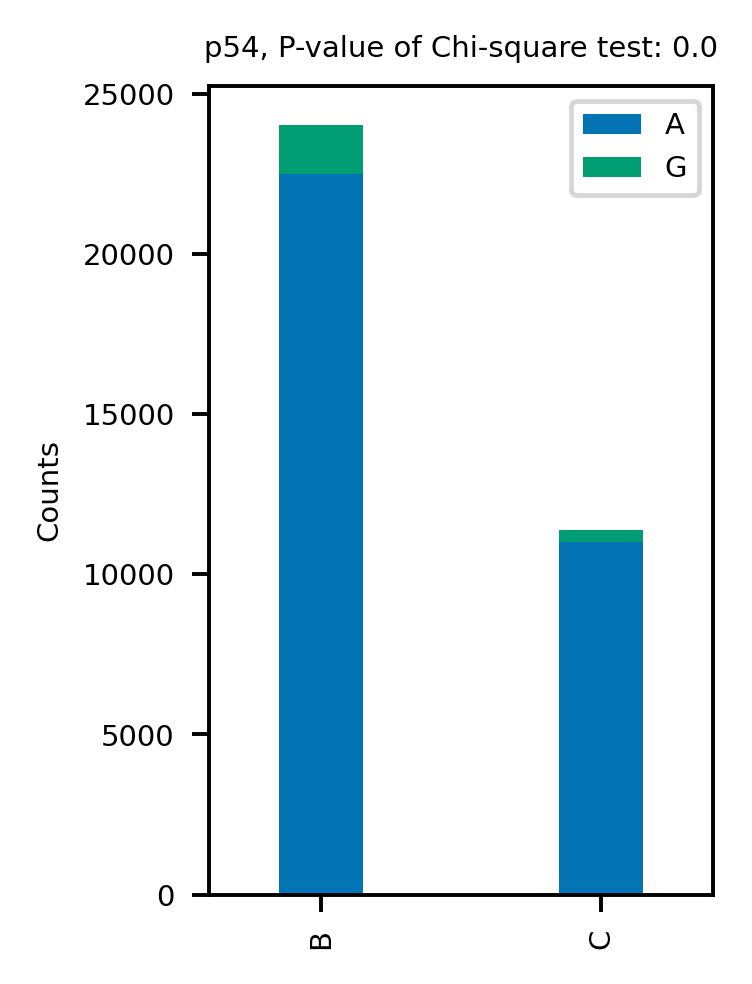

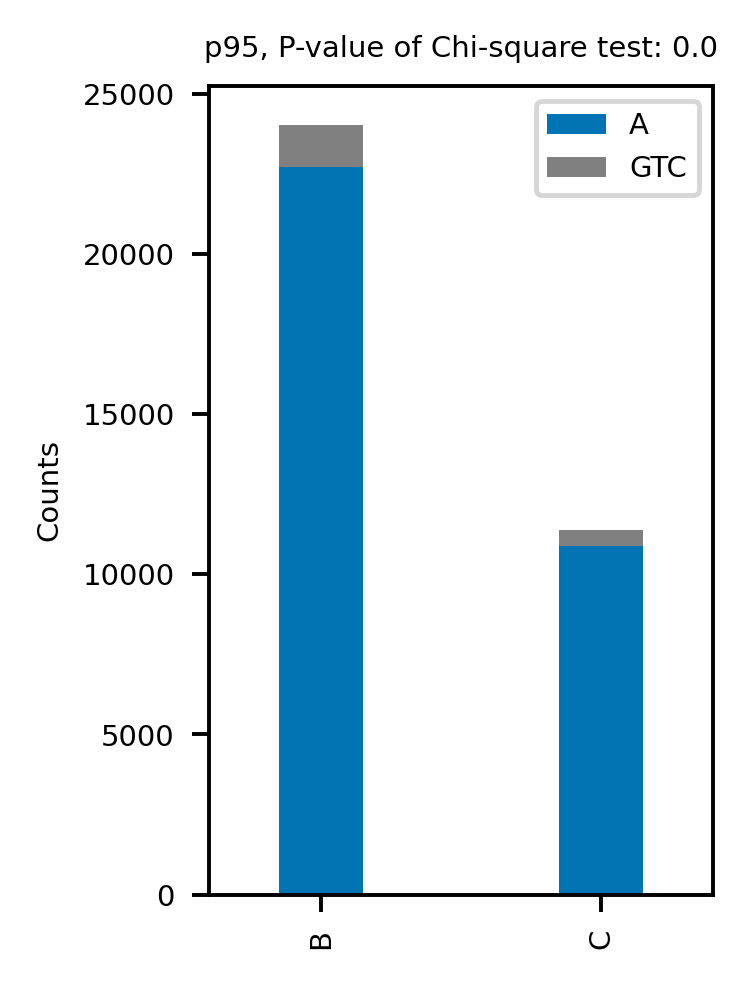

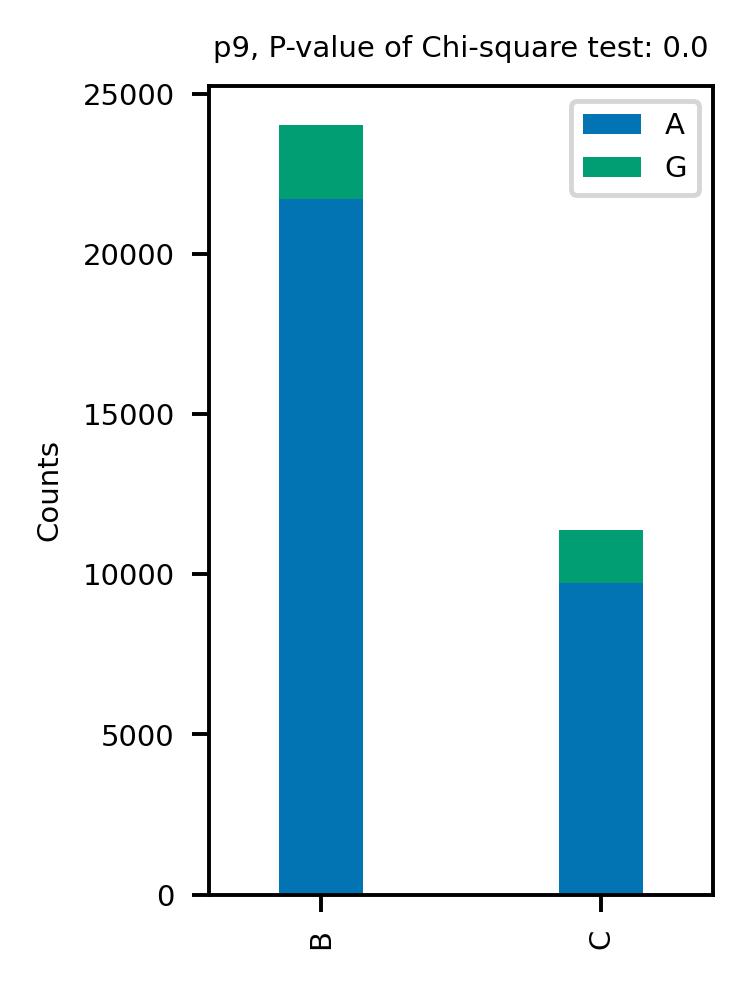

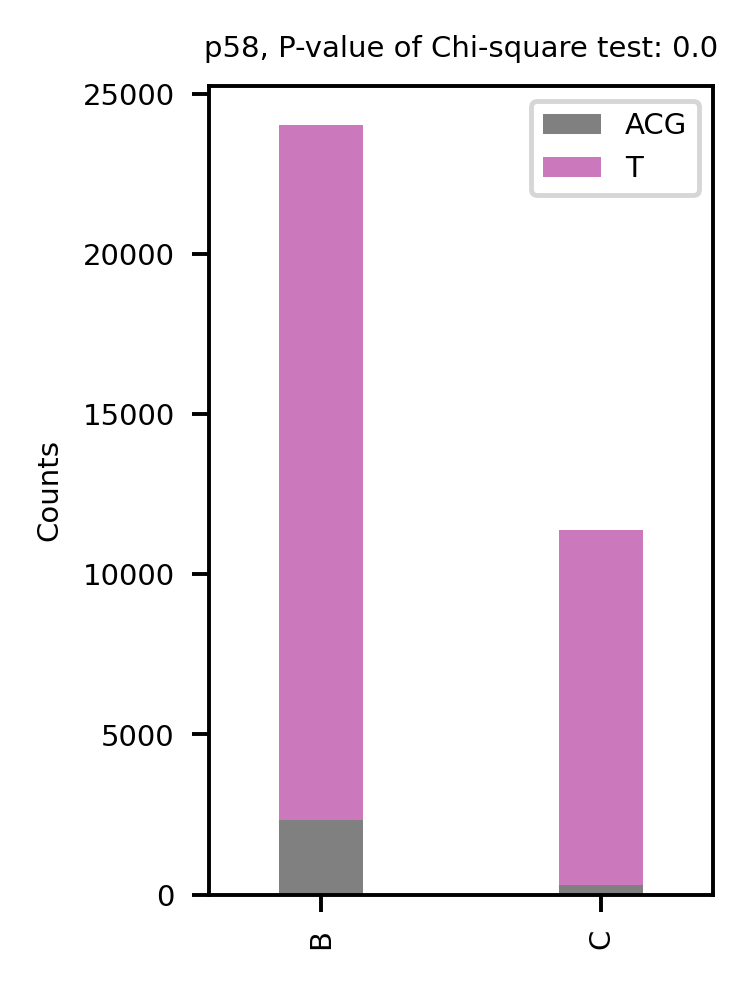

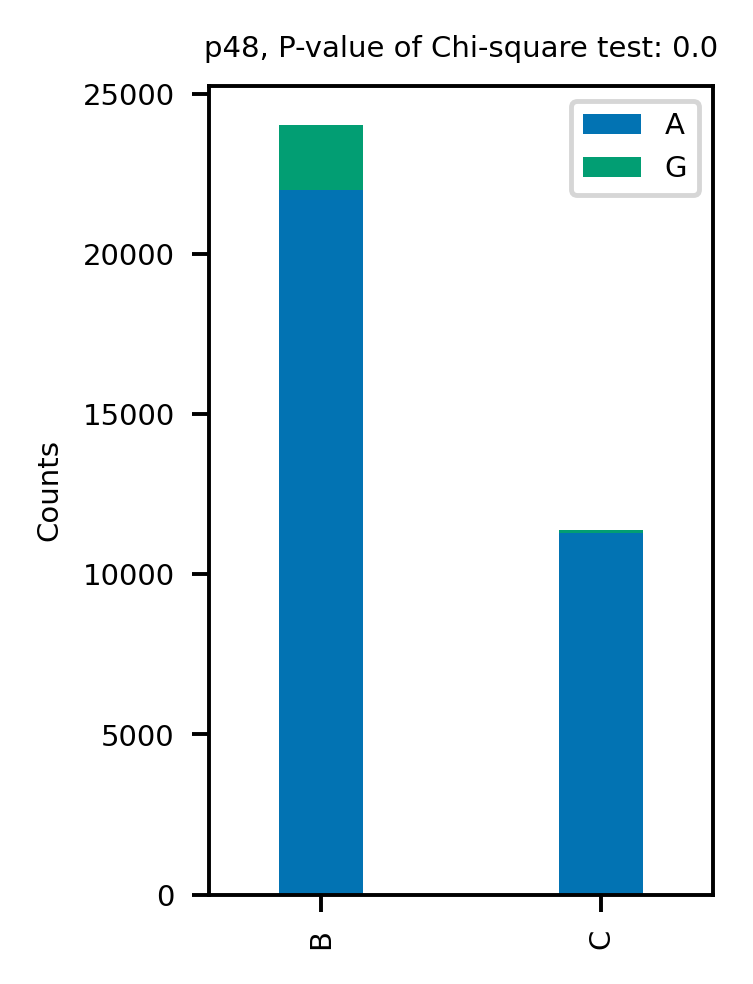

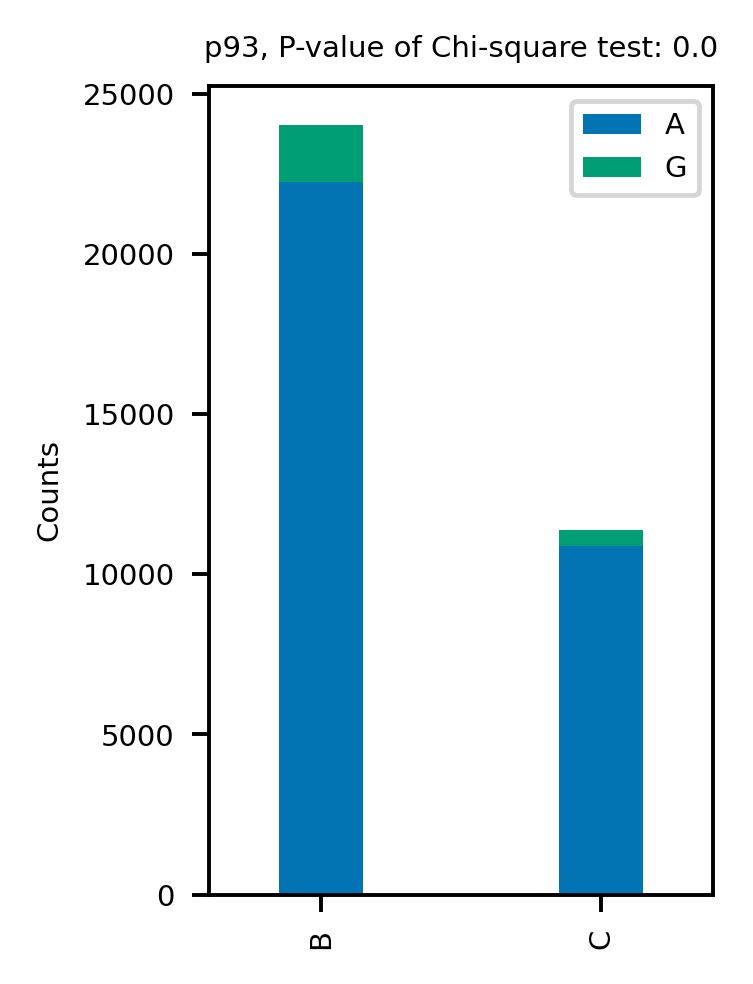

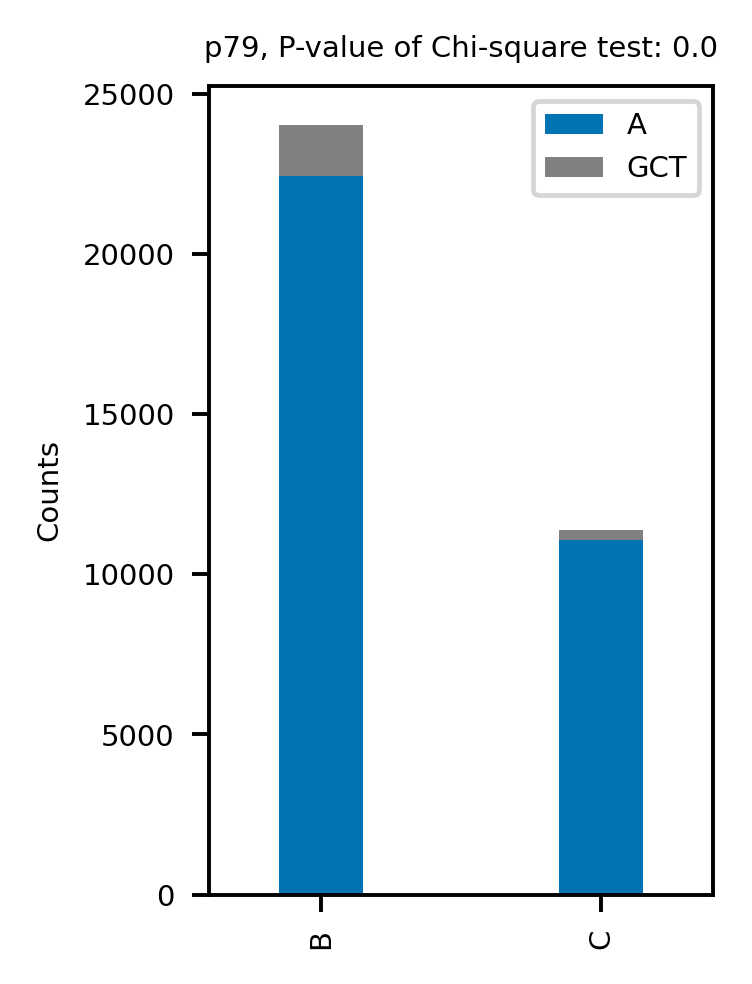

In [28]:
pl = plot_imp_all(final_models=top,
                  X_train=tr, y_train=y,
                  model_type = ana_type,
                  report_dir=report_dir, max_plots=100,
                  figsize=(1.86, 3))

In [30]:
import joblib
load_lgbm = joblib.load(report_dir+'/lgbm.pkl')

In [32]:
load_lgbm

Pipeline(steps=[('prep',
                 Pipeline(steps=[('mc', MisCare(missing_threshold=0.25)),
                                 ('cc', ConstantCare()),
                                 ('ur', URareCare(threshold=0.05)),
                                 ('cc2', ConstantCare()),
                                 ('one_hot', CustomOneHotEncoder()),
                                 ('feature_selection',
                                  FeatureSelection(alpha=0.25, keep=True,
                                                   model_type='cl')),
                                 ('collinear_care',
                                  CollinearCare(dist_method='correlation',
                                                keep=True, threshold=0.25))])),
                ('lgbm', LGBMClassifier(random_state=123))])